In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 440051305


In [3]:
# define the plotting parameters

figsize = (8,4)

In [5]:
# import the data

# choose a TIC ID to analyze
ticid = 440051305  # EW, only 2 sectors of 2min data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 17 2019   SPOC     120   440051305      0.0         N/A
  1 TESS Sector 57 2022   SPOC     120   440051305      0.0      G05003

34654

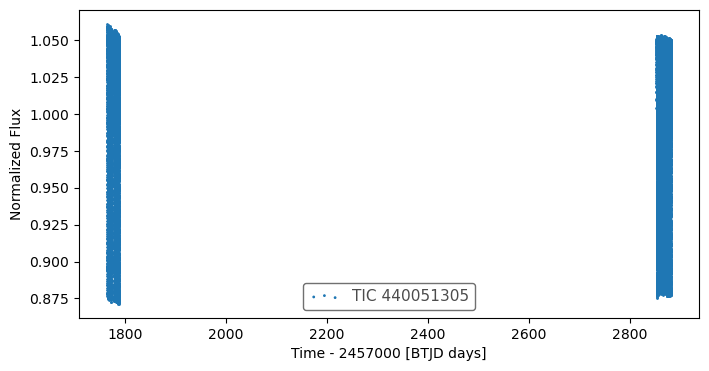

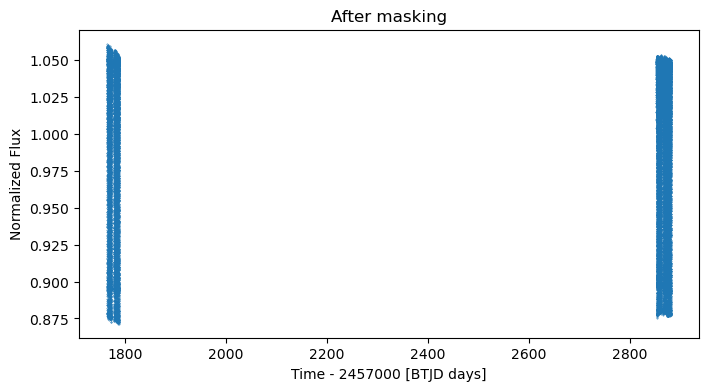

In [6]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

In [7]:
0.16483634532768152 * 2

0.32967269065536303

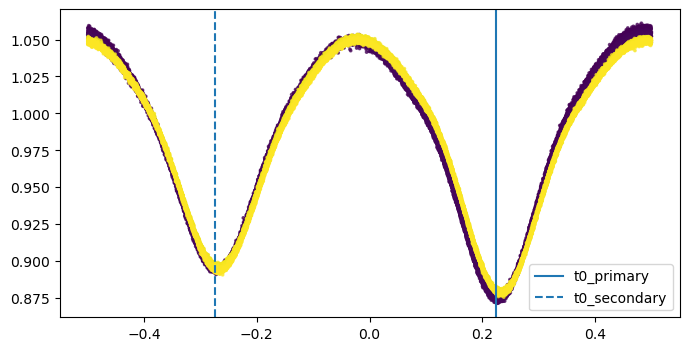

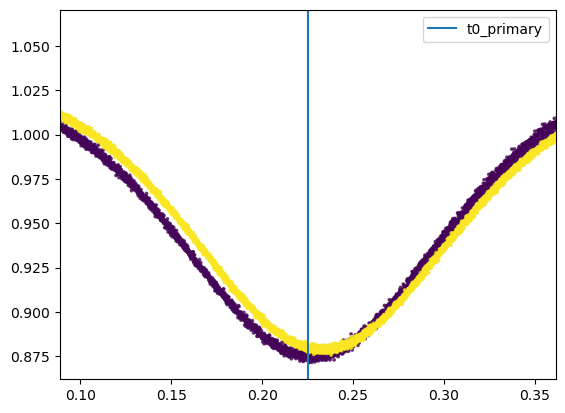

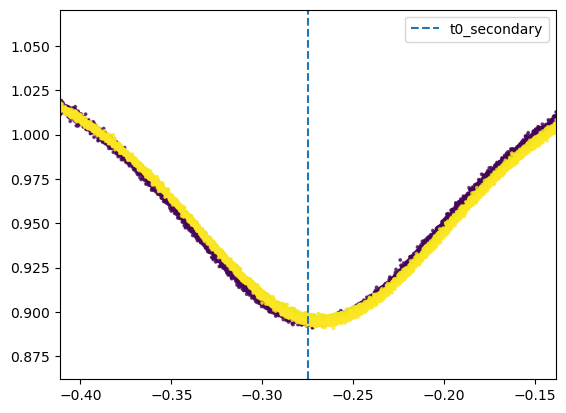

In [30]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# TESS EB (1 sector):  epoch=1765.0601670041478	, period=0.3296756714374497
# VSX: 0.3296745 
# LombSCargle: 0.32967269065536303  (acutal peak: 0.16483634532768152 (half), -0.022878	+0.0227)3	    
# AoV on data primary: 	0.329653 (bins=10)	0.329771 (bins=1)

# FILL-IN THE eclipse epoch / period, 
period = 0.3296727  # LS Period

t0_primary = 1765.06017
t0_secondary = t0_primary + period / 2


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 1.8
duration_hr_secondary = 1.8

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.975, 1.005);
plt.show()

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

Primary:   1764.7304973 0.22499999999980824
window_width_p (phase): 0.27299803714411297
Secondary: 1764.89533365 -0.27499999999992814
window_width_s (phase): 0.27299803714411297


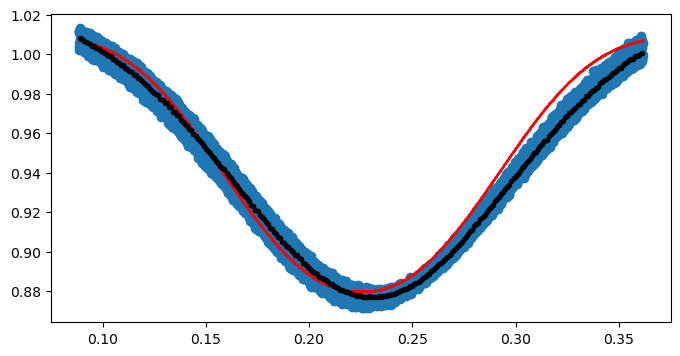

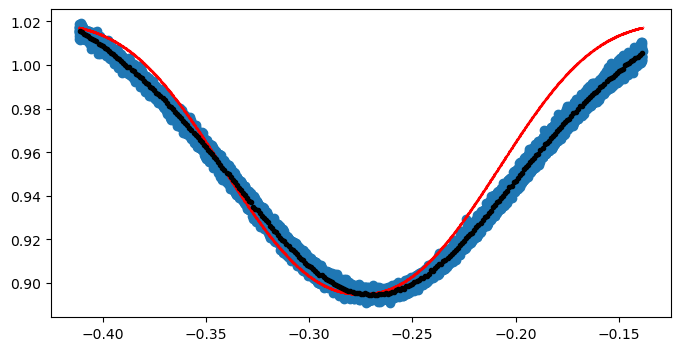

In [43]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.01, -0.13, midpoint_p, 0.06, 1.1]
start_vals_s = [1.02, -0.125, midpoint_s, 0.06, 1.1]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [19]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

100%|██████████████████████████████████████████████████████████| 1000/1000 [03:27<00:00,  4.82it/s]


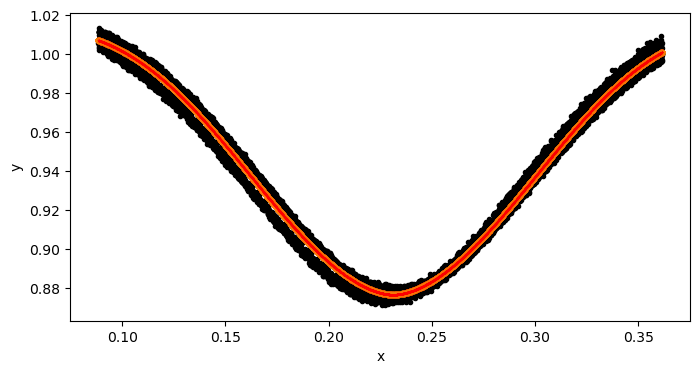

100%|██████████████████████████████████████████████████████████| 1000/1000 [03:34<00:00,  4.66it/s]


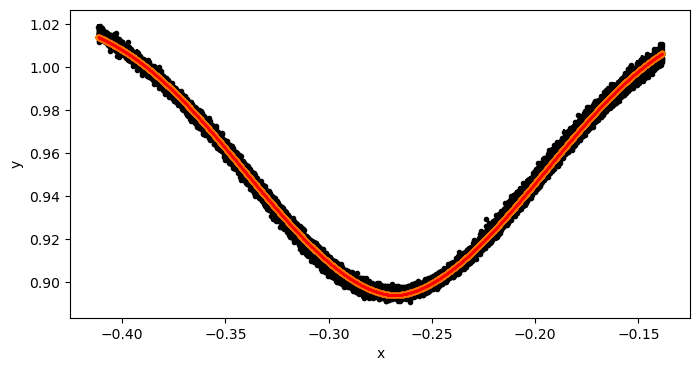

In [44]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [46]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0148412739248864, -0.1382231493062348, 0.2312342989509577, 0.07127284131143338, 0.888418197129901
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])

    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0236974229571598, -0.12982154789033262, -0.26792291349889563, 0.07502819879844122, 0.8811107790471274
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [45]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0148412739248864, -0.1382231493062348, 0.2312342989509577, 0.07127284131143338, 0.888418197129901
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0236974229571598, -0.12982154789033262, -0.26792291349889563, 0.07502819879844122, 0.8811107790471274


3389

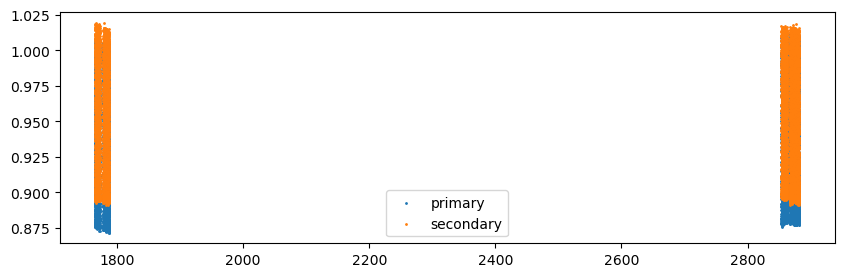

In [47]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1764.7304973 0.3296727 1764.7304973


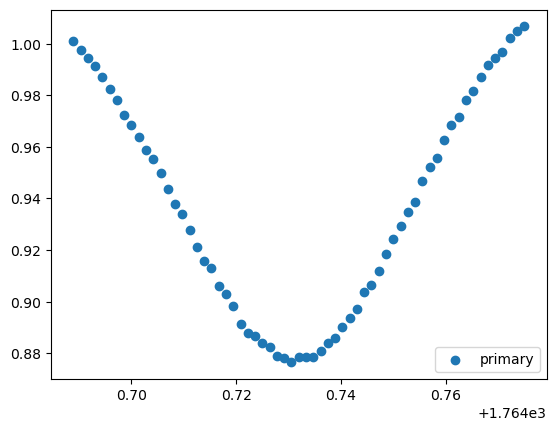

1764.7304973 0.3296727 1765.06017


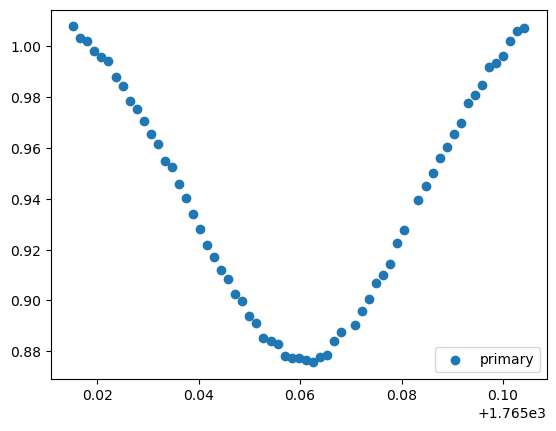

1764.7304973 0.3296727 1765.3898427


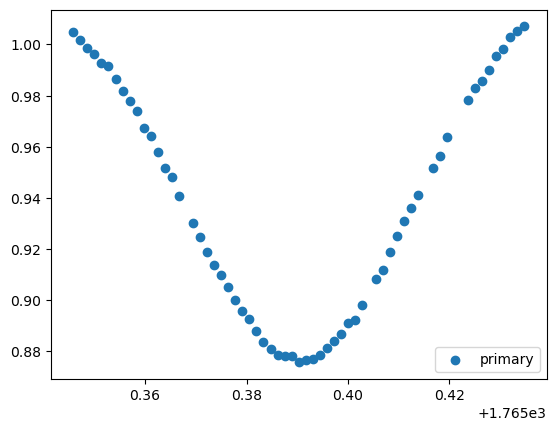

1764.89533365 0.3296727 1764.89533365


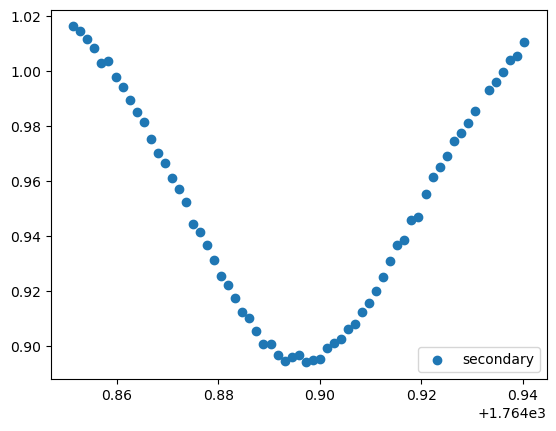

1764.89533365 0.3296727 1765.22500635


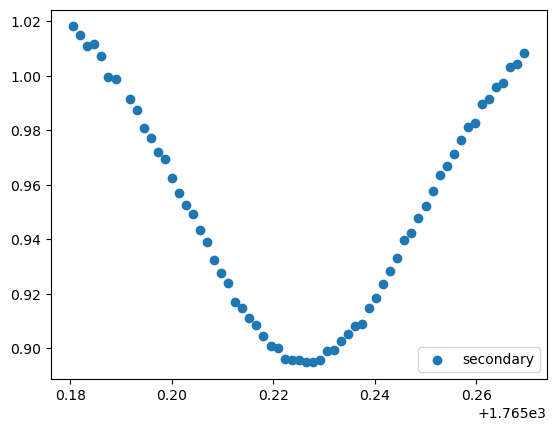

1764.89533365 0.3296727 1765.55467905


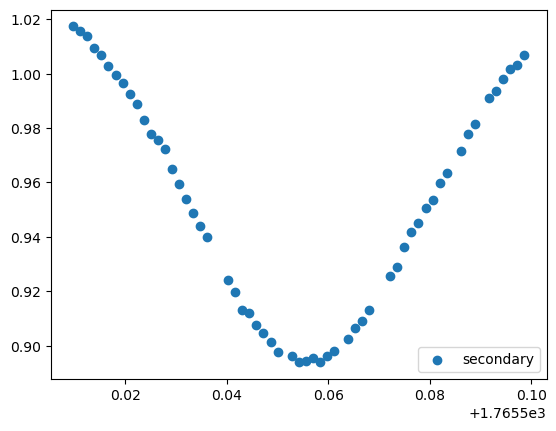

In [48]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has al

100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.38it/s]


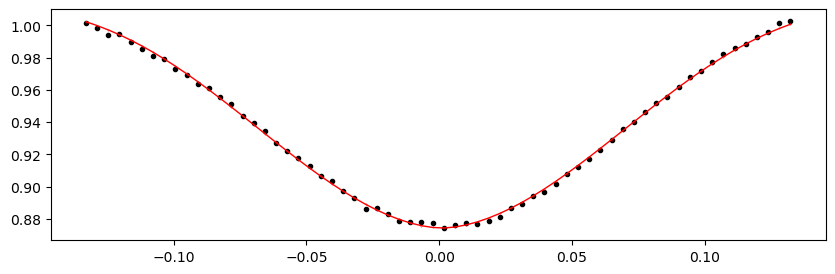

1771.9832967 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.74it/s]


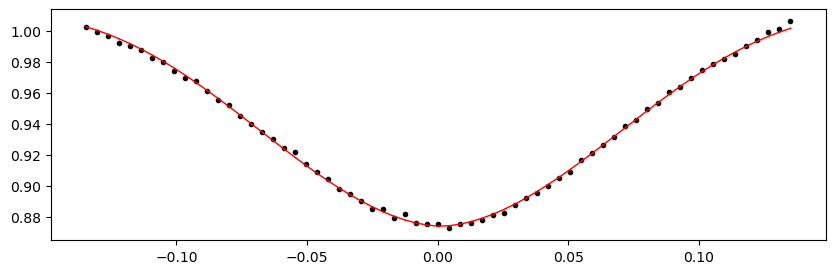

1772.3129694 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.58it/s]


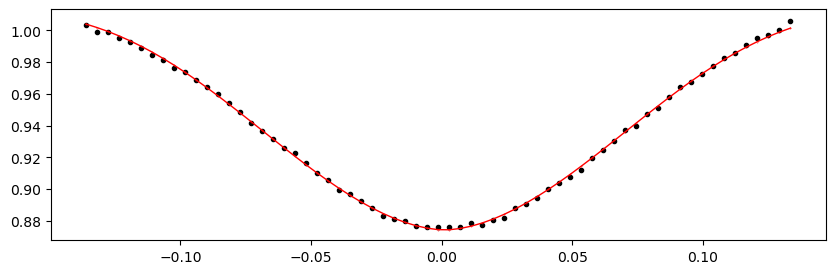

1772.6426421 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.21it/s]


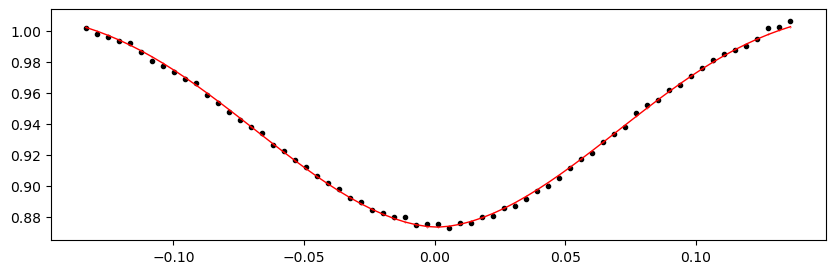

1777.9174053 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.53it/s]


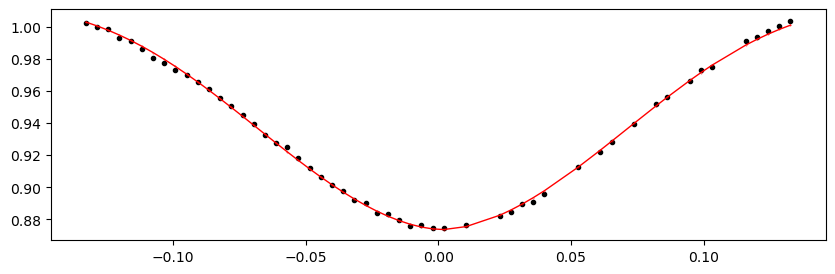

1778.247078 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.38it/s]


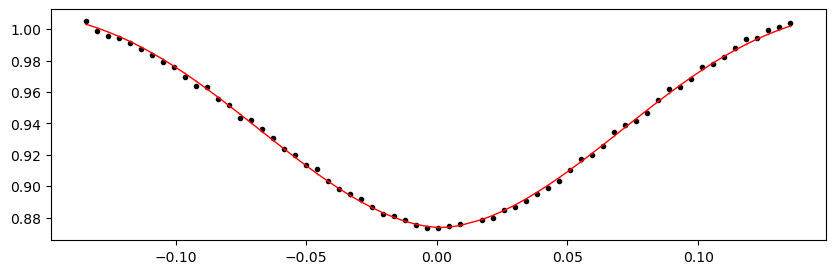

1778.5767507 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.48it/s]


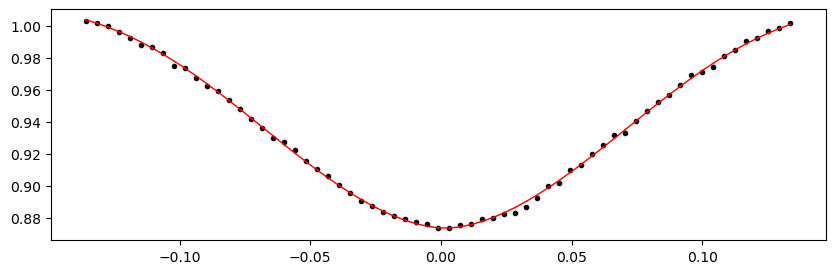

1778.9064234 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.87it/s]


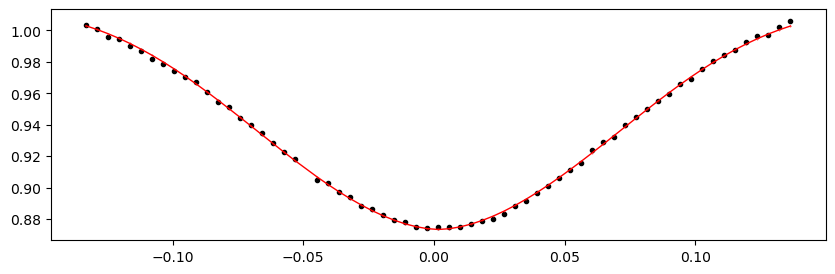

1779.2360961 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.35it/s]


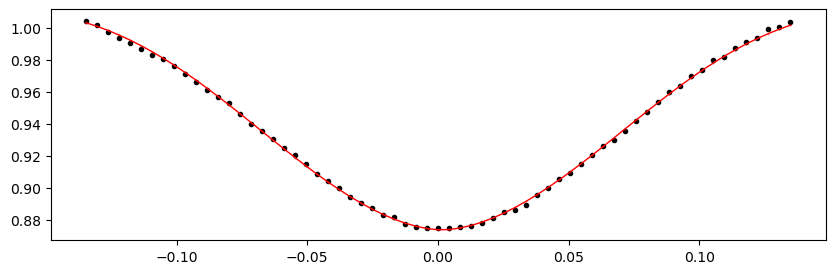

1779.5657688000001 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.82it/s]


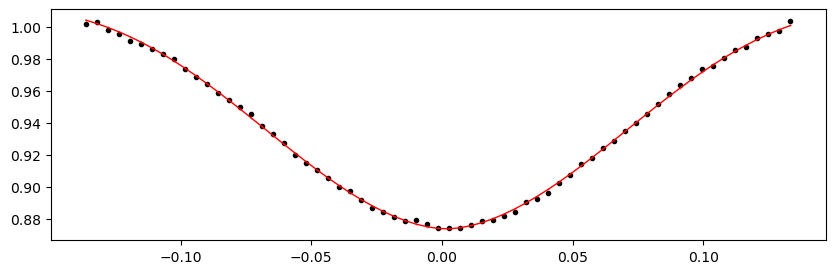

1779.8954415 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.01it/s]


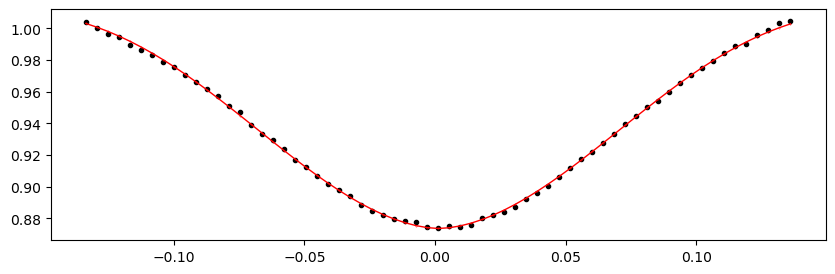

1780.2251142 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.99it/s]


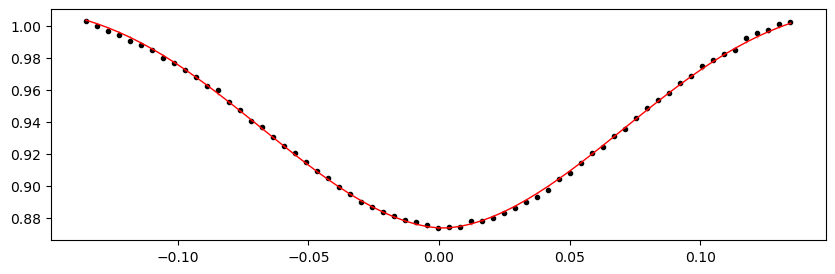

1780.5547869 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.32it/s]


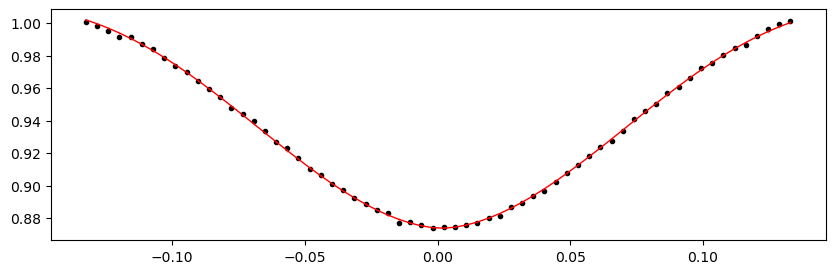

1780.8844596000001 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.64it/s]


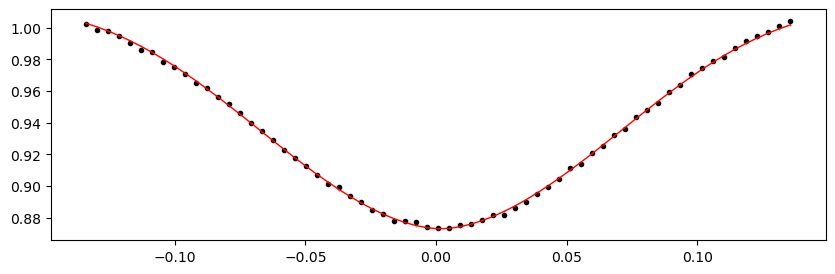

1781.2141323 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.55it/s]


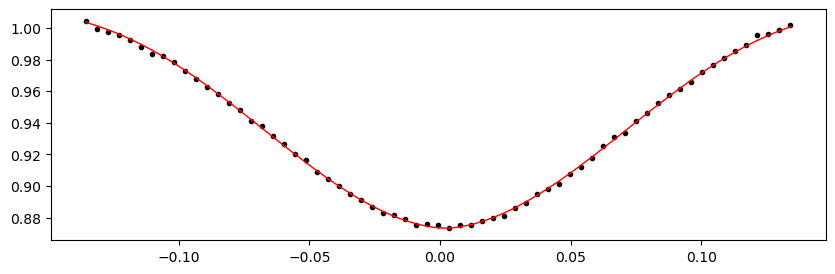

1781.543805 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.17it/s]


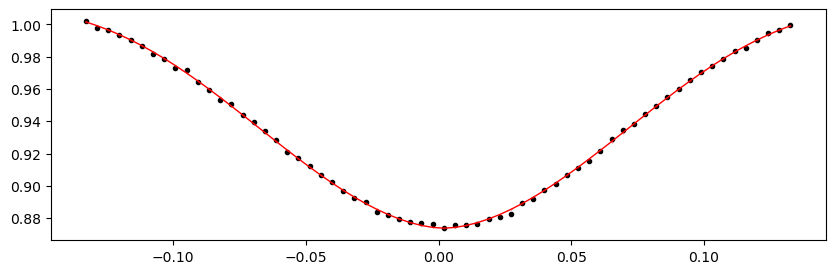

1781.8734777 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.93it/s]


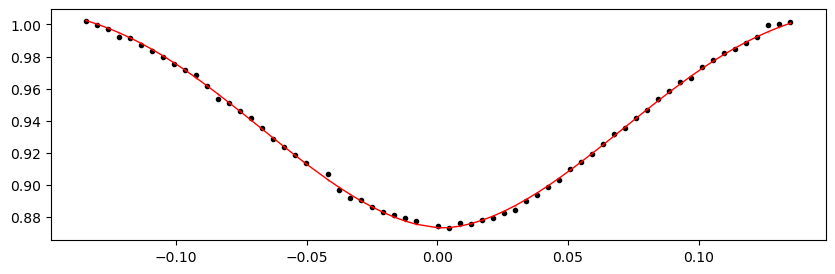

1782.2031504 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.85it/s]


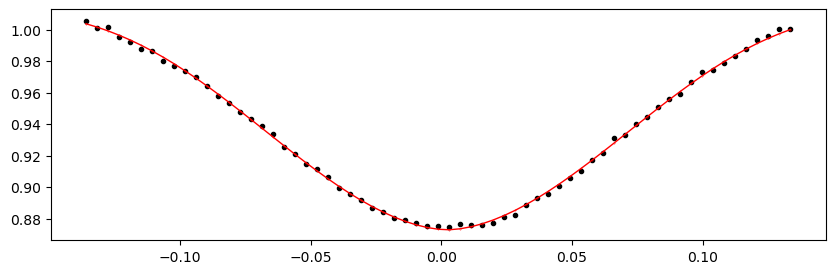

1782.5328231 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.17it/s]


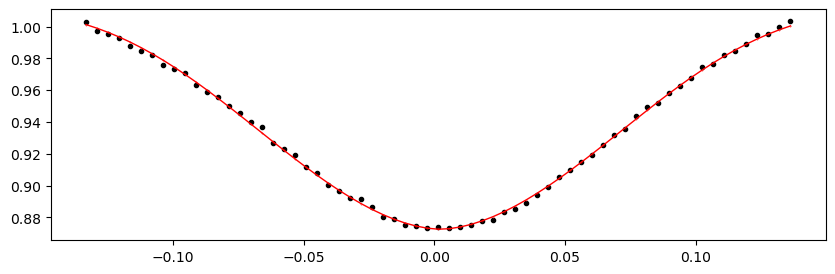

1782.8624958 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.90it/s]


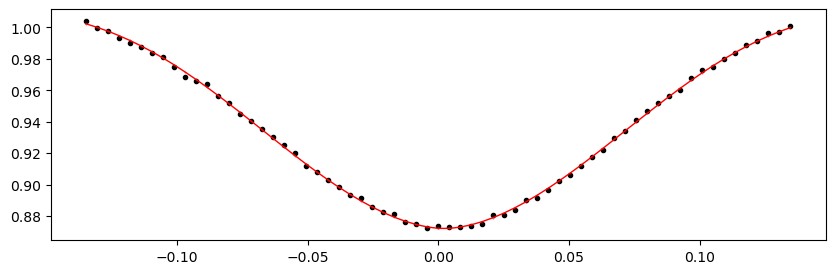

1783.1921685 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.83it/s]


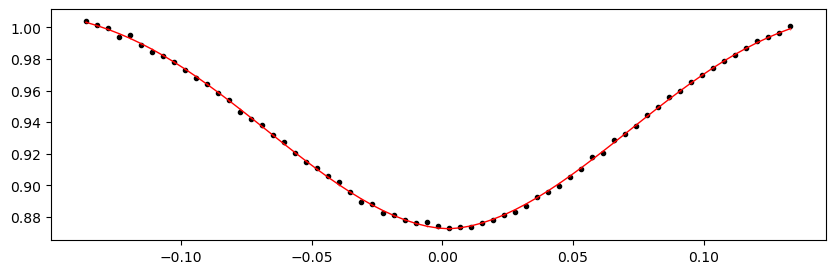

1783.5218412 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.10it/s]


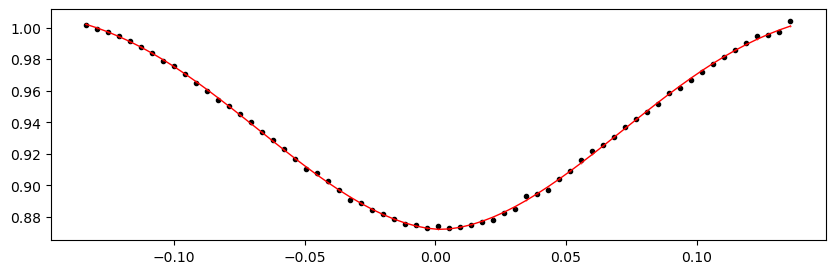

1783.8515139 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.90it/s]


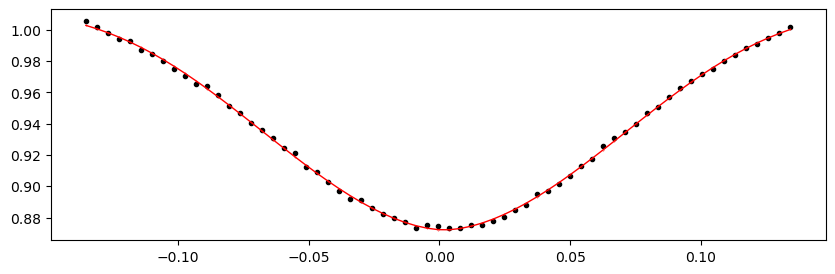

1784.1811866 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.43it/s]


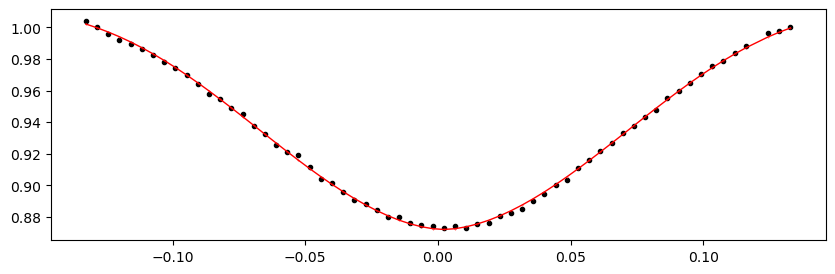

1784.5108593 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.32it/s]


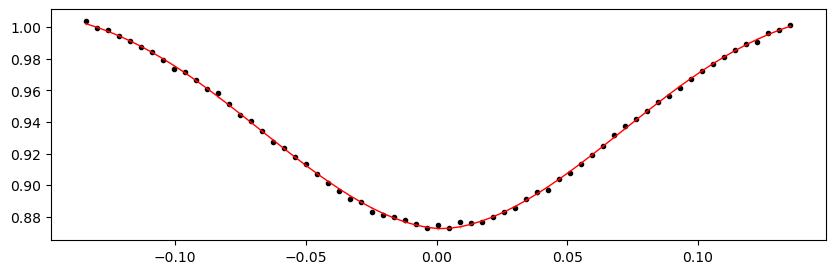

1784.840532 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.84it/s]


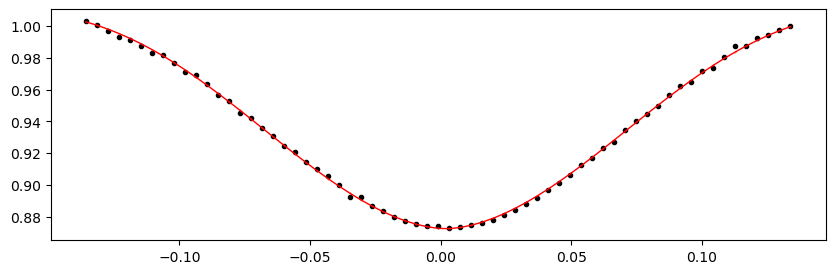

1785.1702047 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.62it/s]


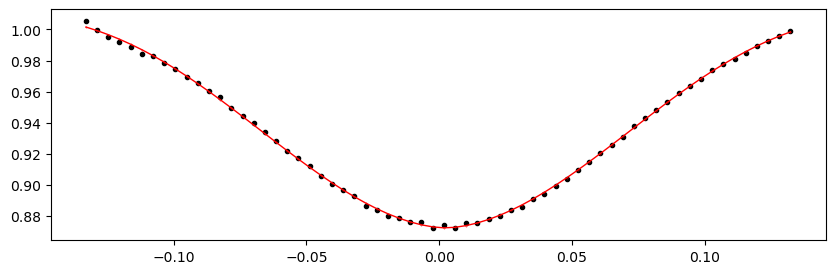

1785.4998774 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.61it/s]


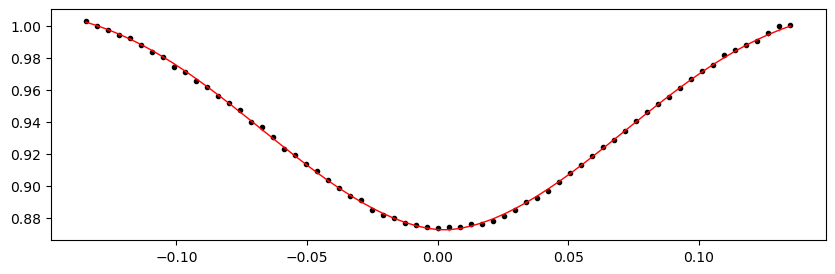

1785.8295501 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.59it/s]


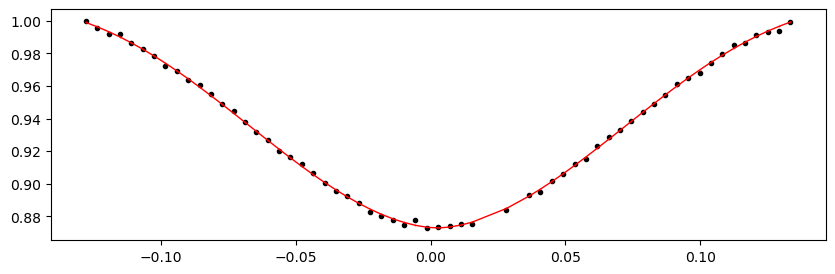

1786.1592228 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.12it/s]


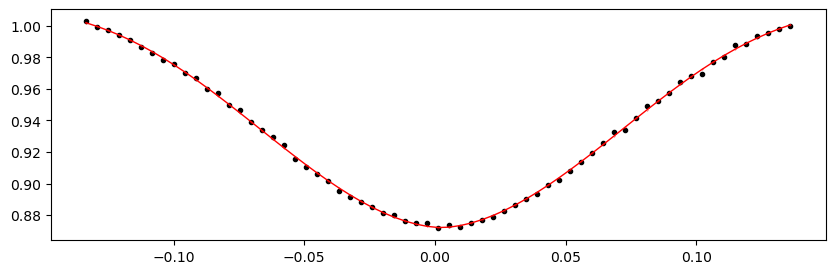

1786.4888955000001 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.11it/s]


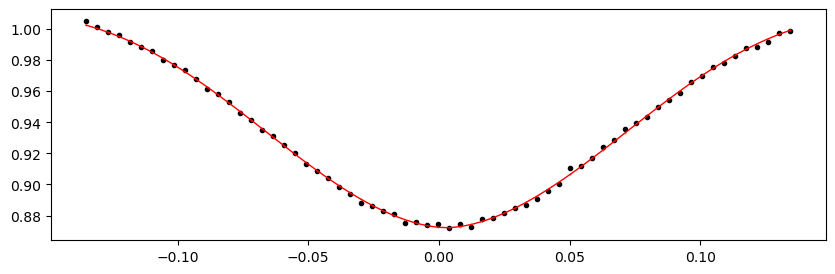

1786.8185682 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.62it/s]


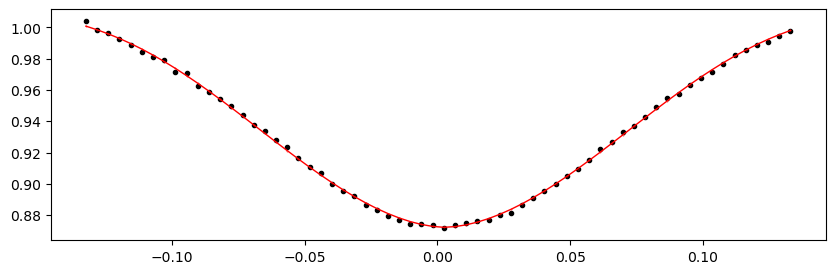

1787.1482409 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.36it/s]


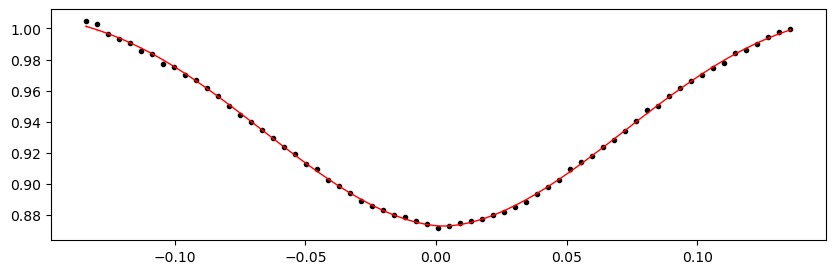

1787.4779136 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.61it/s]


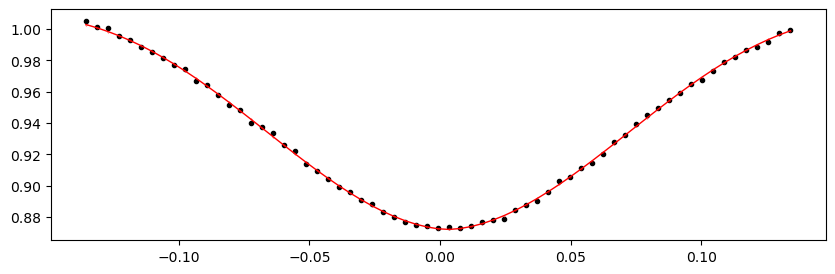

1787.8075863 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.36it/s]


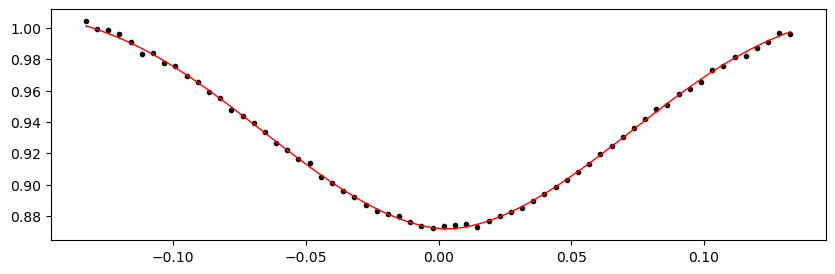

2853.6394253999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.05it/s]


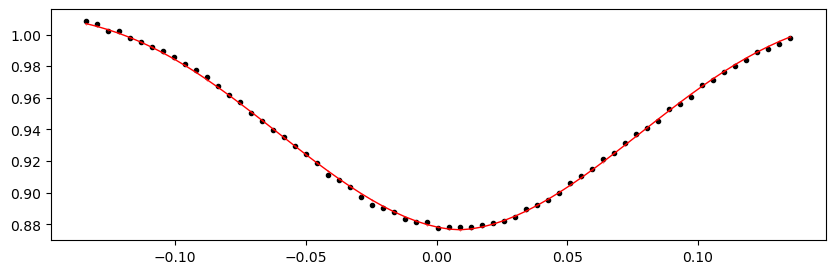

2853.9690981 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.34it/s]


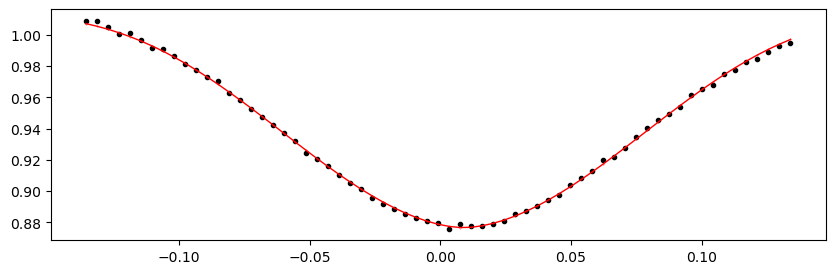

2854.2987708 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.14it/s]


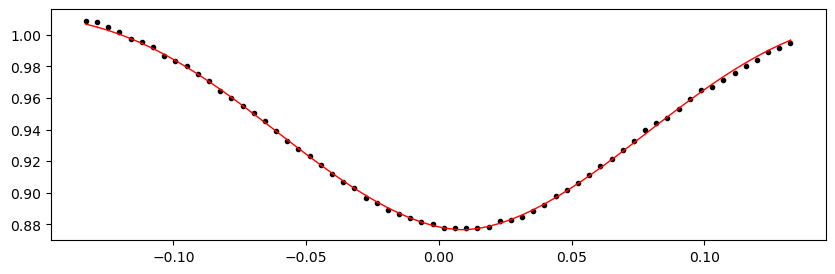

2854.6284435 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.26it/s]


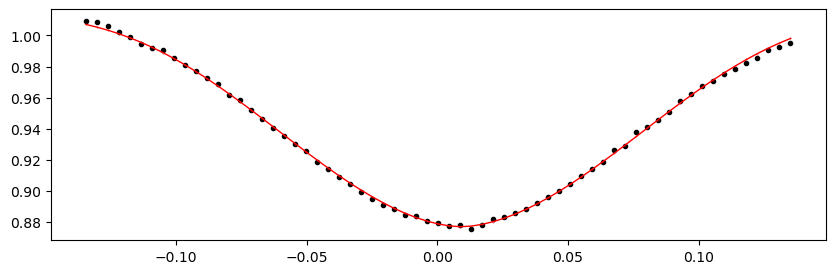

2854.9581162 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.82it/s]


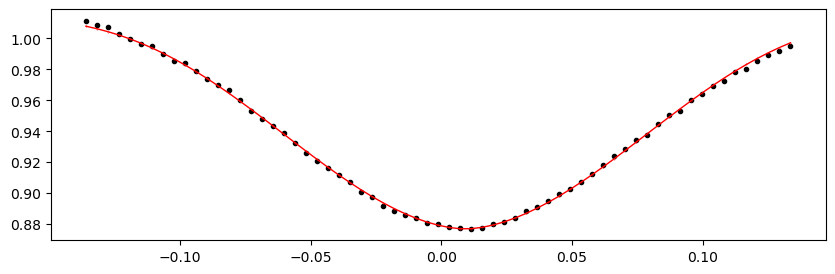

2855.2877889 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.60it/s]


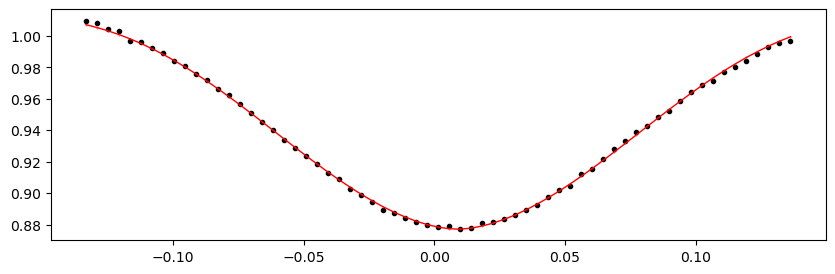

2855.6174616 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.52it/s]


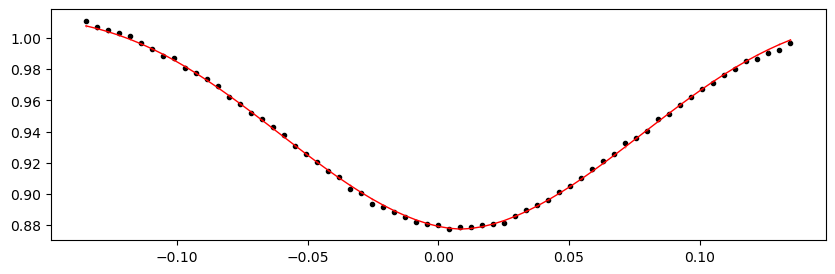

2855.9471343 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.11it/s]


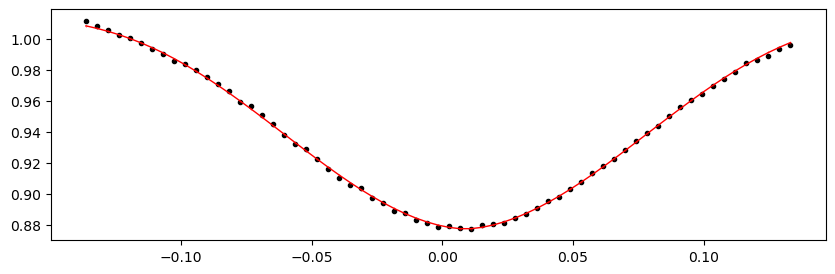

2856.276807 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.42it/s]


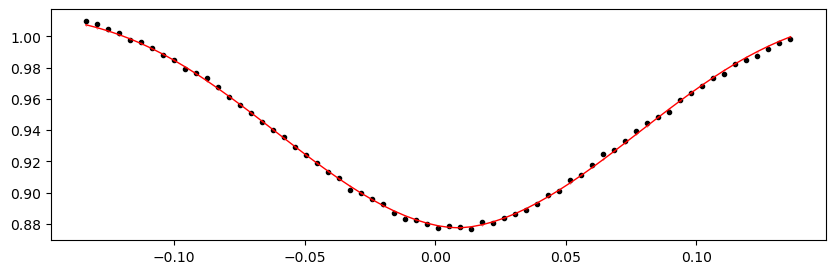

2856.6064797 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.63it/s]


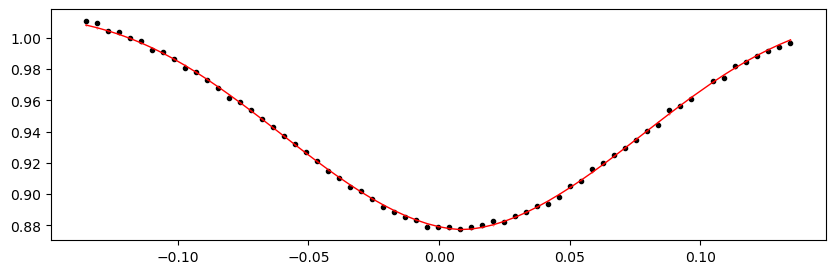

2856.9361524 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.34it/s]


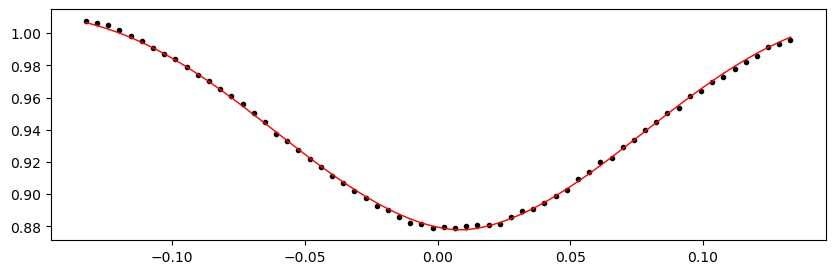

2857.2658251000003 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.87it/s]


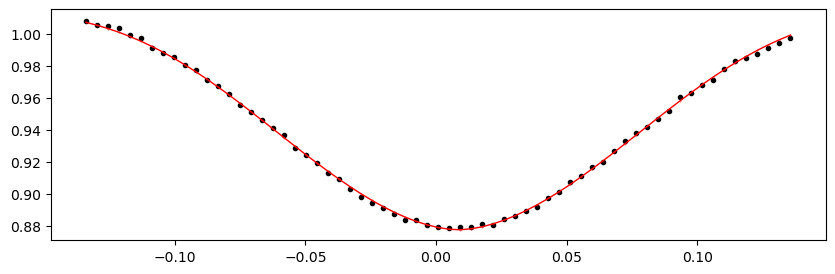

2857.5954978 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.30it/s]


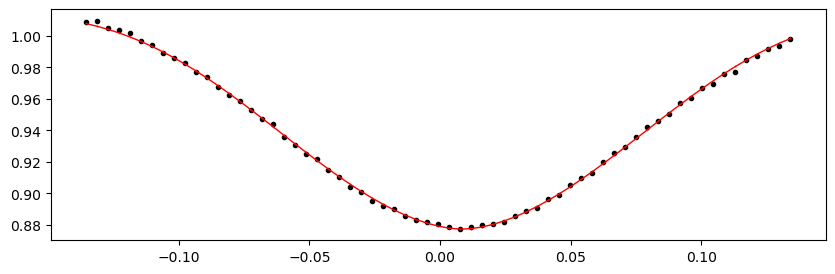

2857.9251704999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.08it/s]


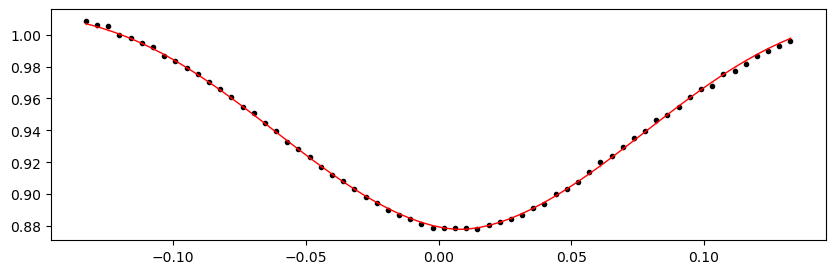

2858.2548432 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.37it/s]


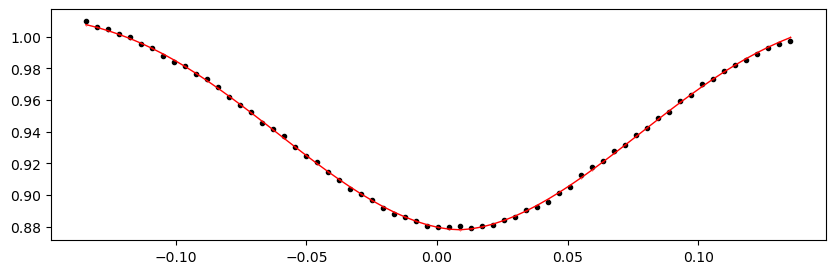

2858.5845159 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.08it/s]


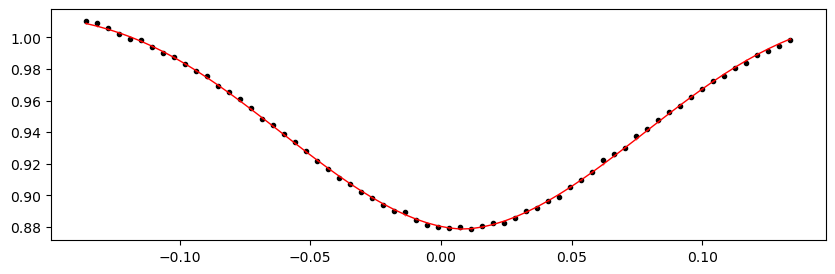

2858.9141885999998 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.86it/s]


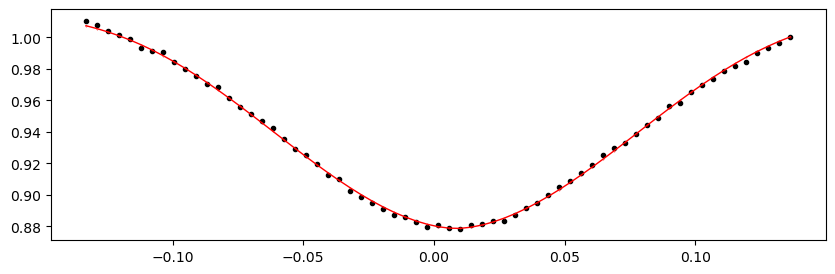

2859.2438613 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.38it/s]


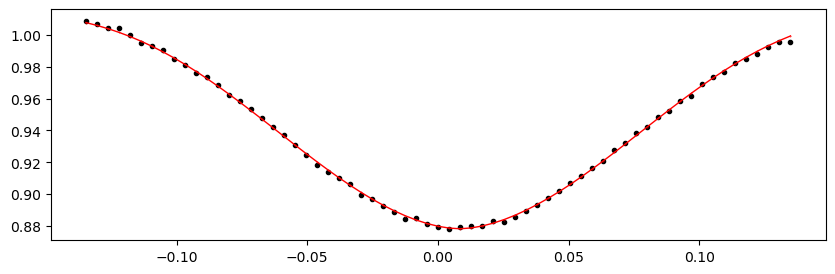

2859.573534 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.14it/s]


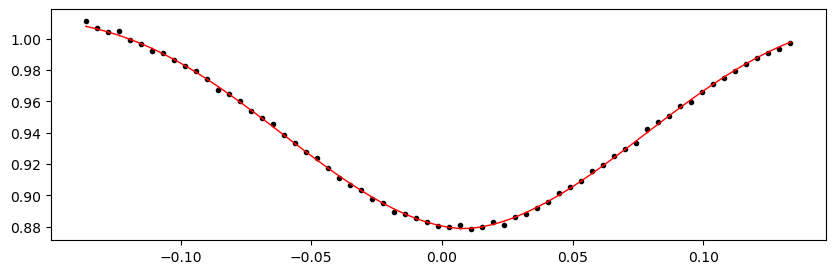

2859.9032067 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.47it/s]


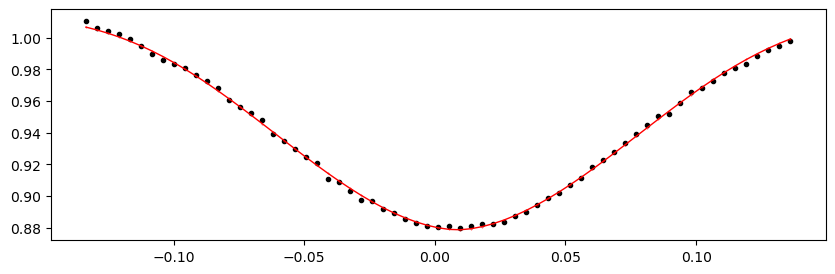

2860.2328794 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.64it/s]


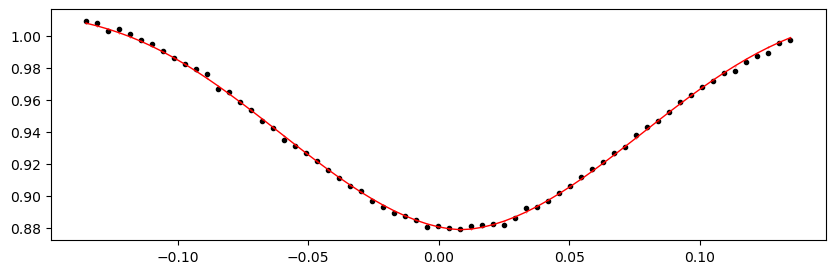

2860.5625521 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.14it/s]


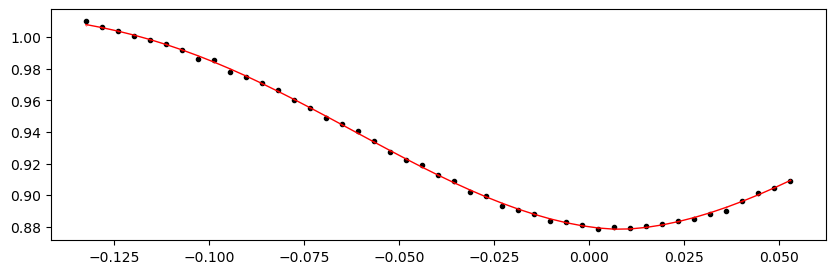

2860.8922248 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.31it/s]


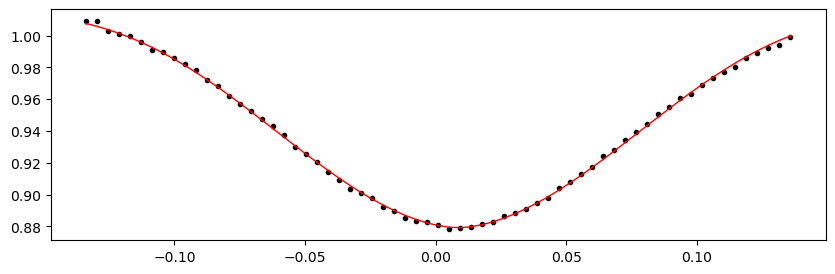

2861.2218975 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.60it/s]


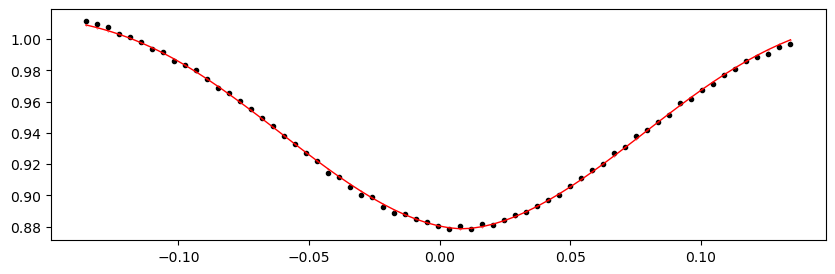

2861.5515702000002 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.65it/s]


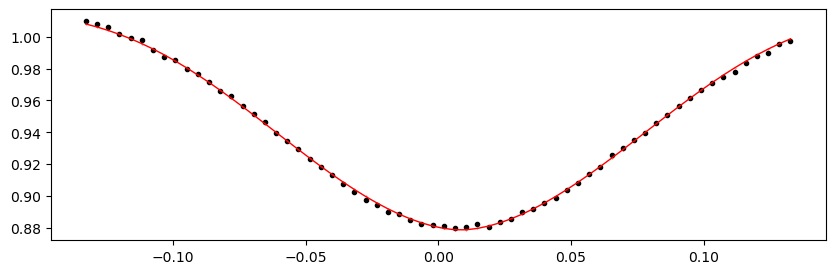

2861.8812429 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.71it/s]


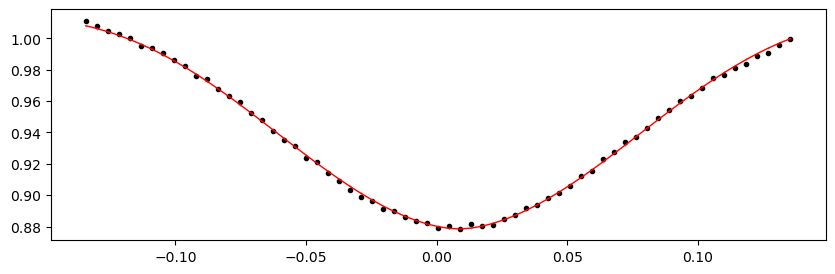

2862.2109155999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.10it/s]


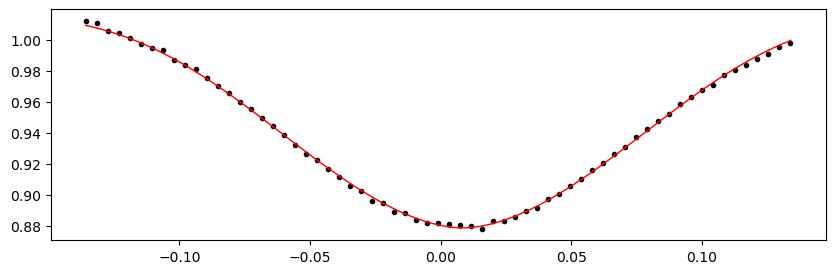

2862.5405883000003 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.34it/s]


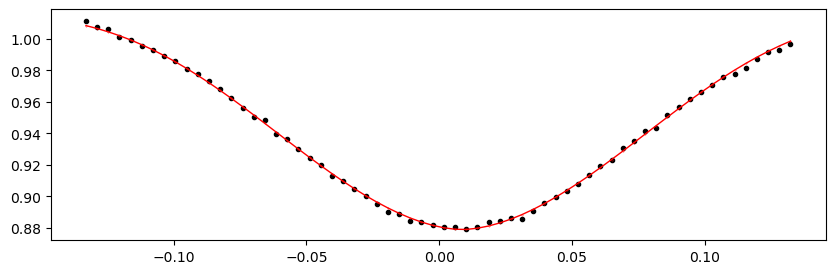

2862.870261 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.67it/s]


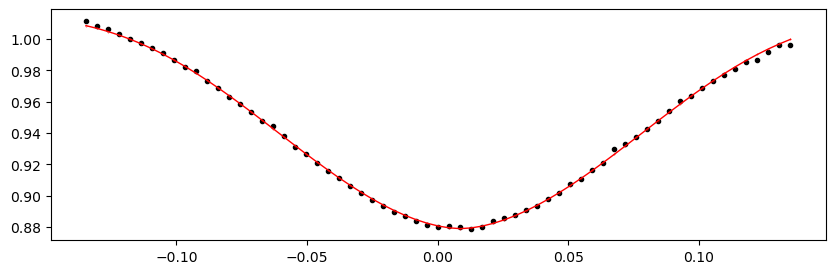

2863.1999336999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.60it/s]


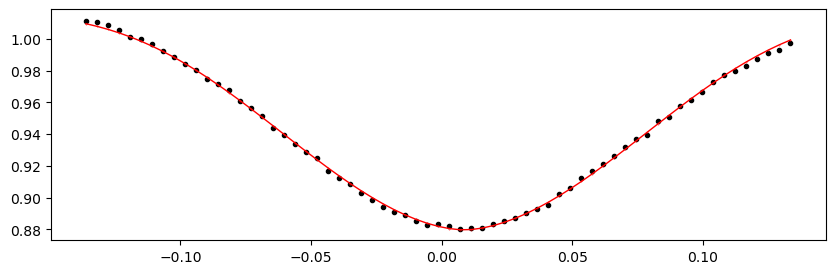

2866.4966606999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.83it/s]


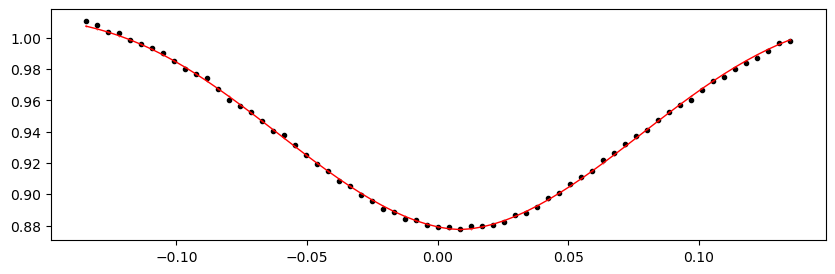

2866.8263334000003 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.07it/s]


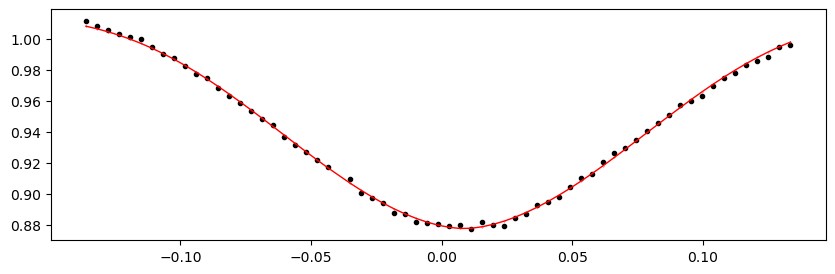

2867.1560061 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.94it/s]


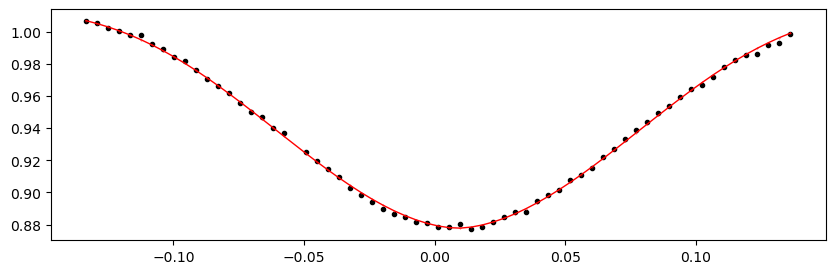

2867.4856787999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.99it/s]


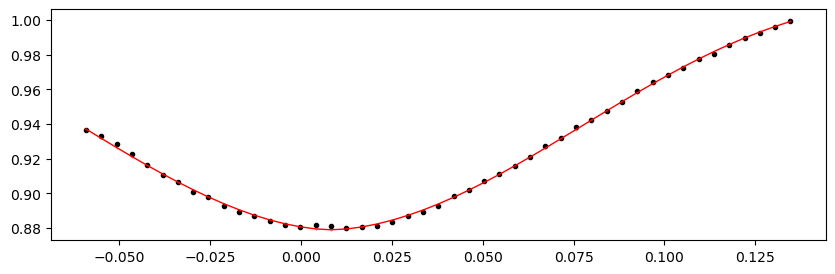

2867.8153515 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.26it/s]


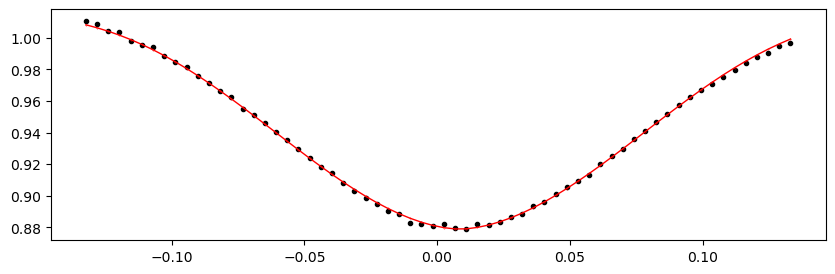

2868.1450242 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.01it/s]


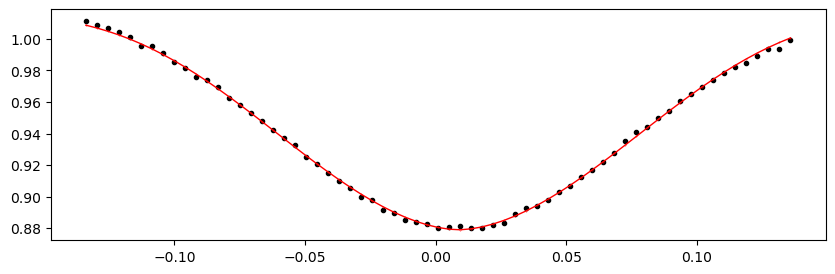

2868.4746969 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.01it/s]


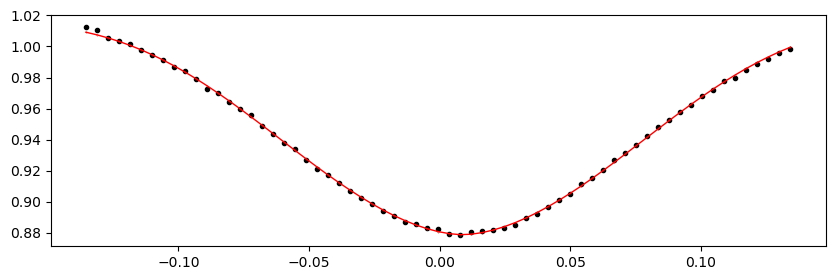

2868.8043696 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.90it/s]


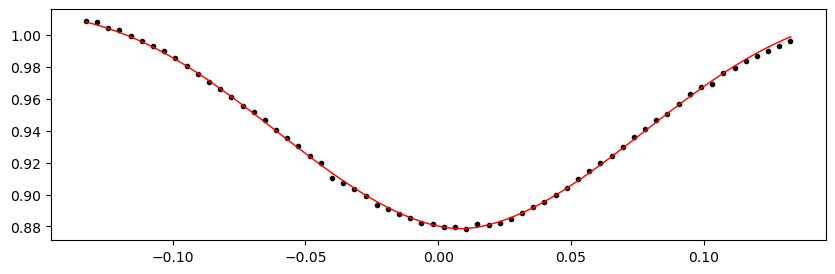

2869.1340423 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.21it/s]


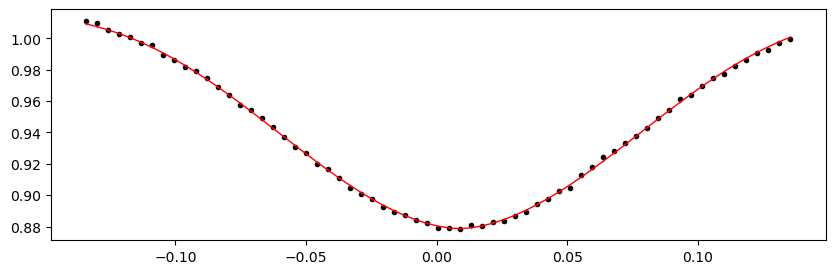

2869.463715 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.71it/s]


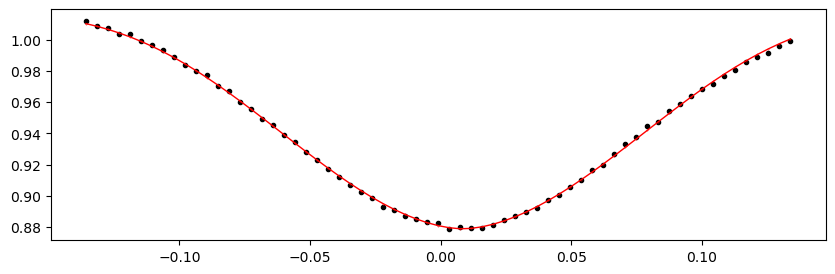

2869.7933877 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.42it/s]


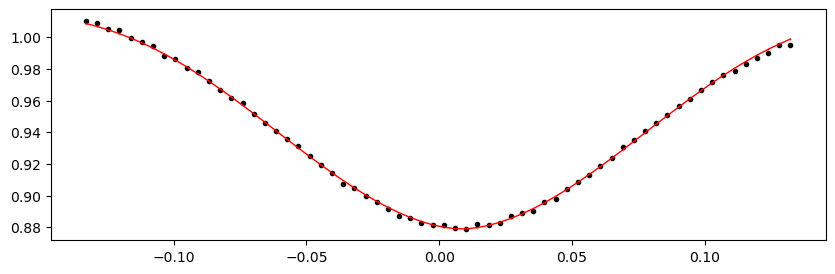

2870.1230604 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.87it/s]


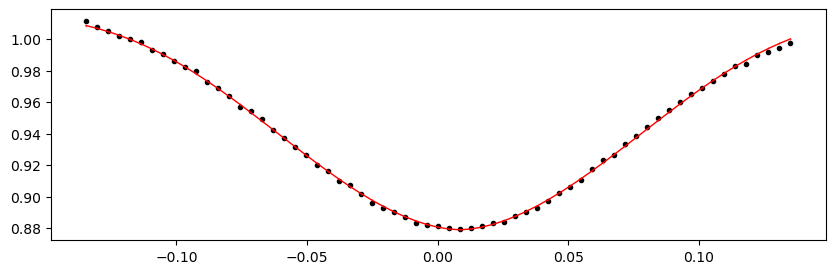

2870.4527331 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.32it/s]


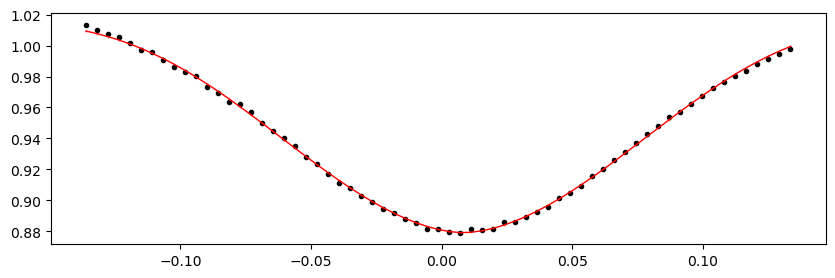

2870.7824057999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.47it/s]


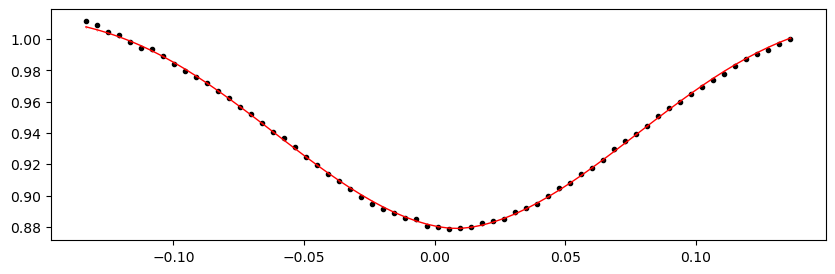

2871.1120785000003 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.65it/s]


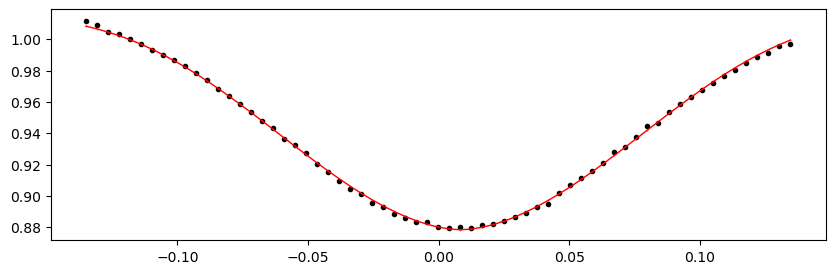

2871.4417512 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.04it/s]


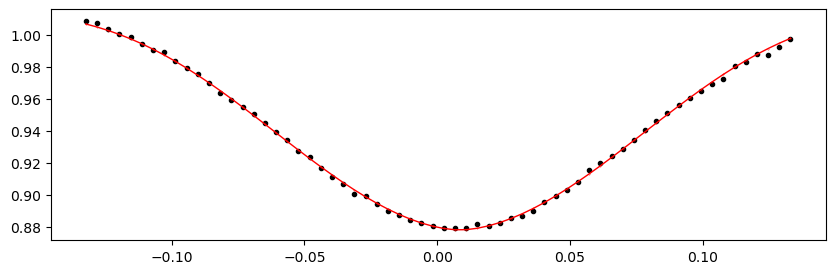

2871.7714238999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.03it/s]


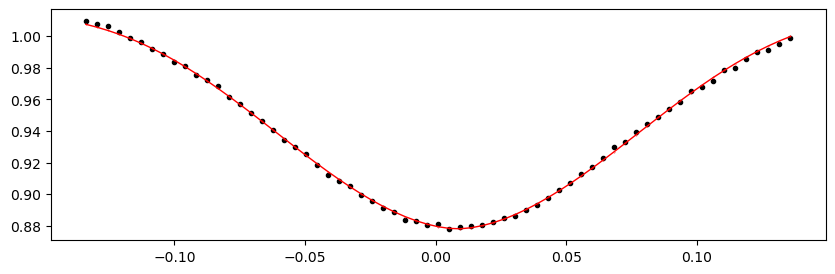

2872.1010966 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.08it/s]


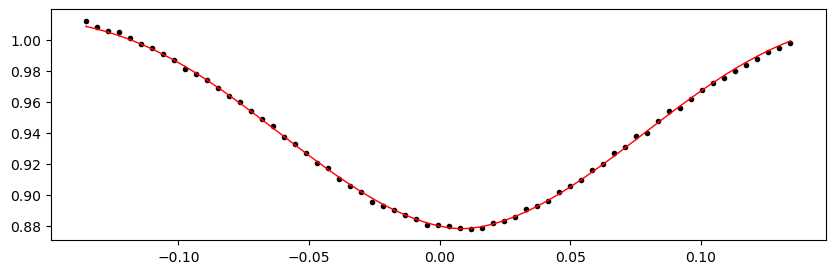

2872.4307693 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.40it/s]


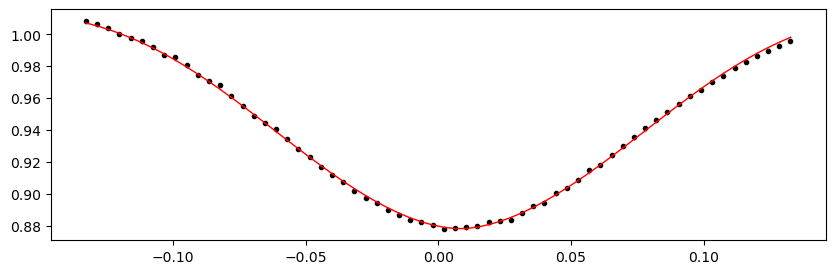

2872.760442 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.46it/s]


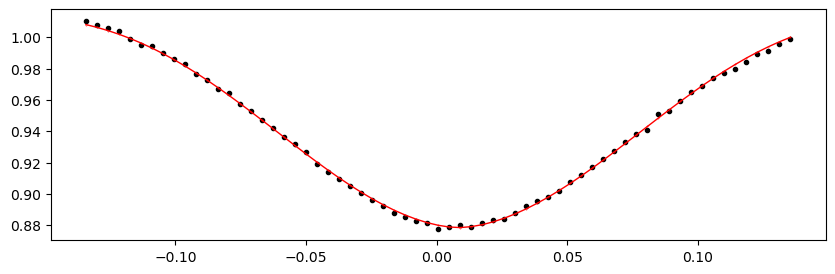

2873.0901147 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.19it/s]


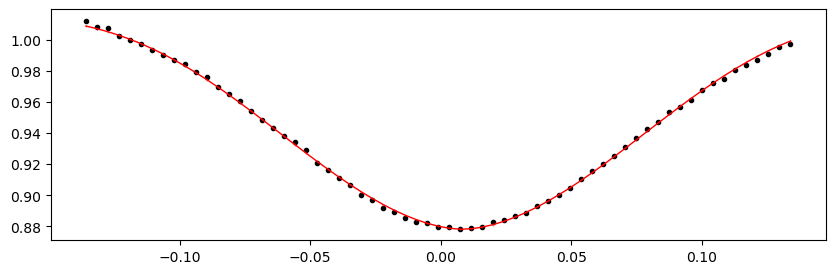

2873.4197874 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.91it/s]


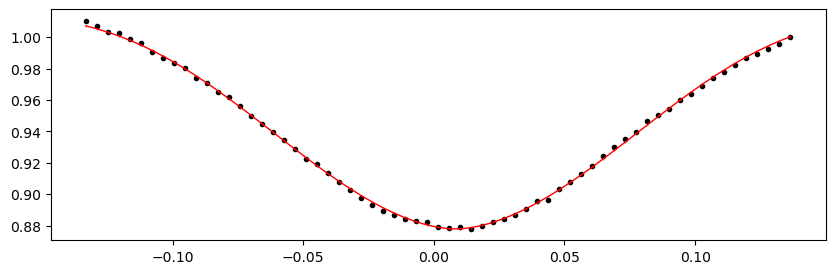

2873.7494601 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.97it/s]


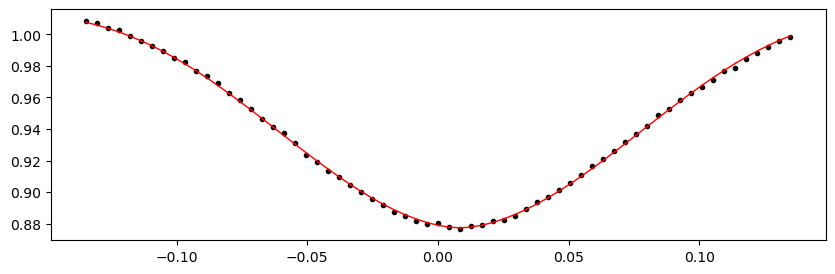

2874.0791328 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.66it/s]


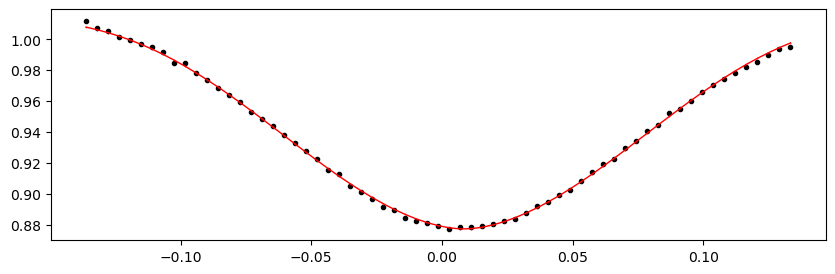

2874.4088055 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.16it/s]


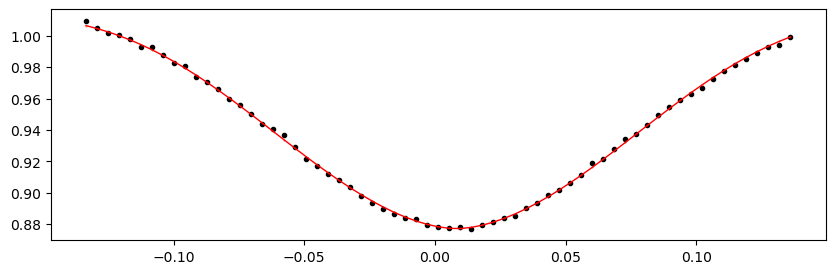

2875.0681508999996 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.43it/s]


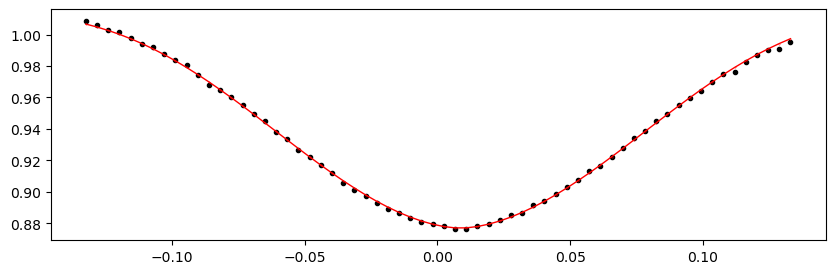

2875.3978236000003 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.11it/s]


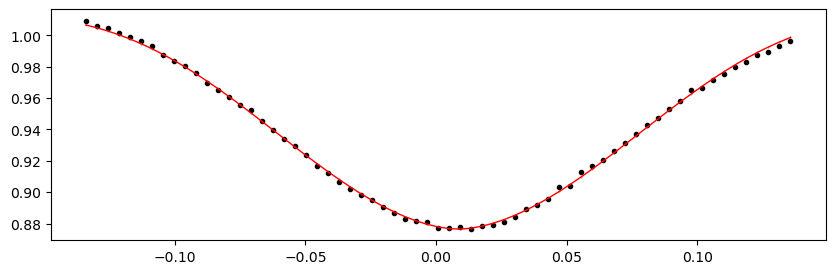

2875.7274963 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.62it/s]


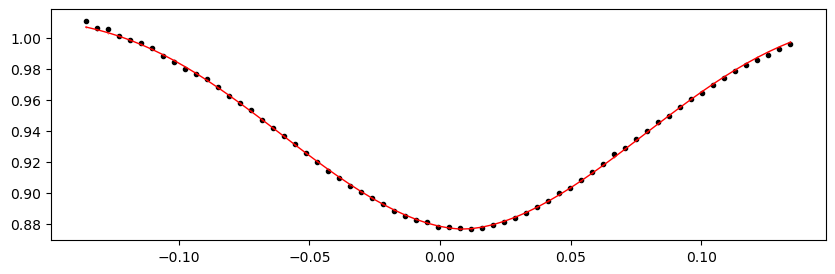

2876.0571689999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.62it/s]


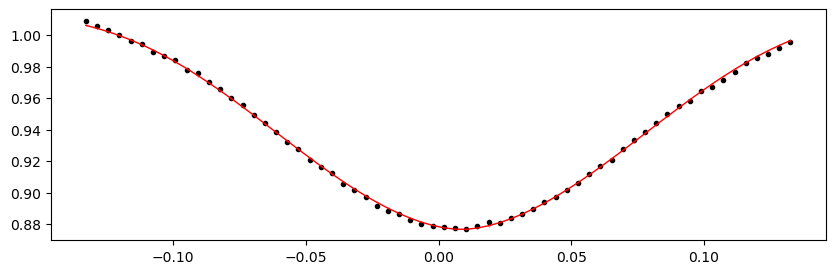

2876.3868417 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.45it/s]


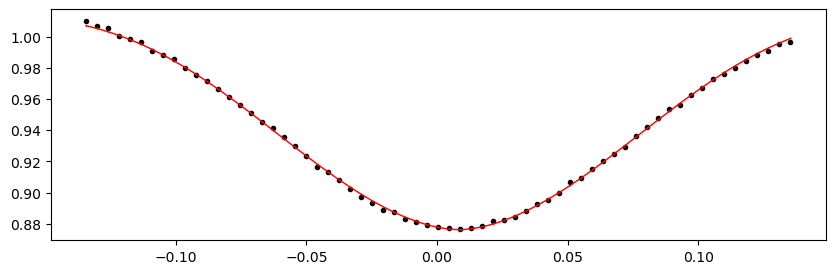

2876.7165144 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.84it/s]


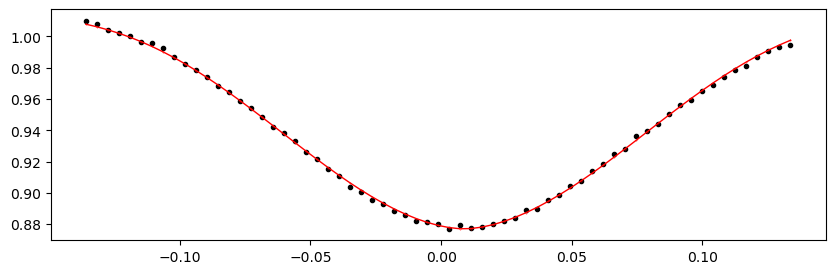

2877.0461870999998 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.03it/s]


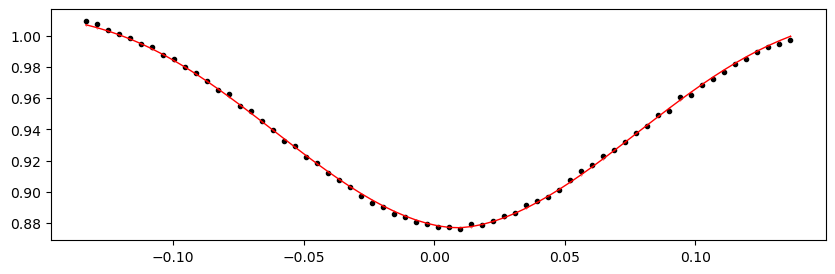

2877.3758598 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.35it/s]


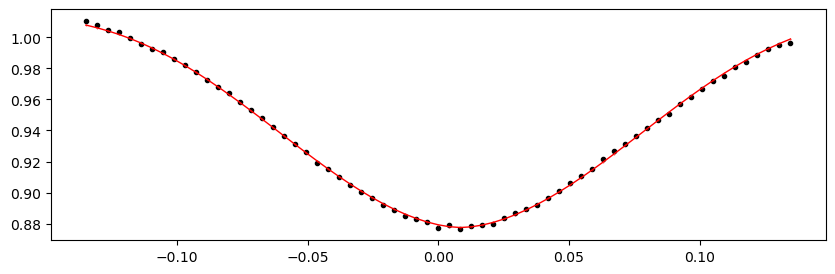

2877.7055325 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.40it/s]


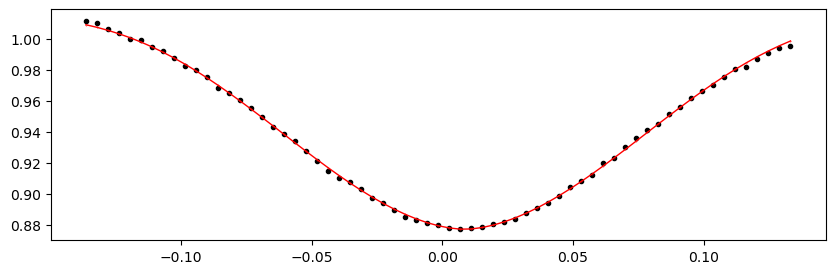

2878.0352052 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.90it/s]


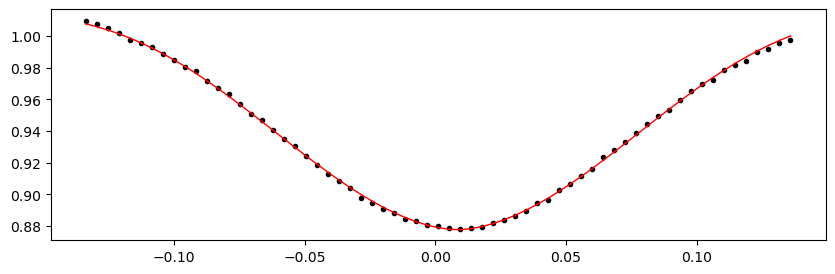

2878.3648779 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.64it/s]


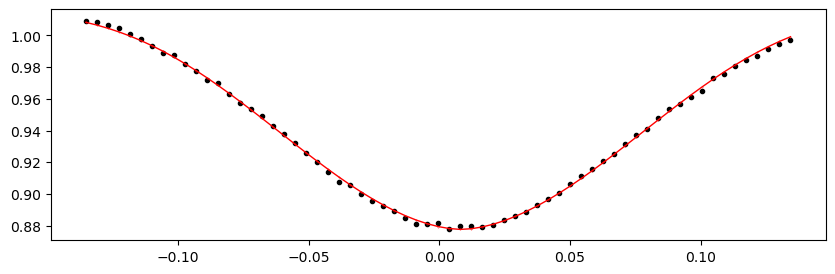

2878.6945506 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.90it/s]


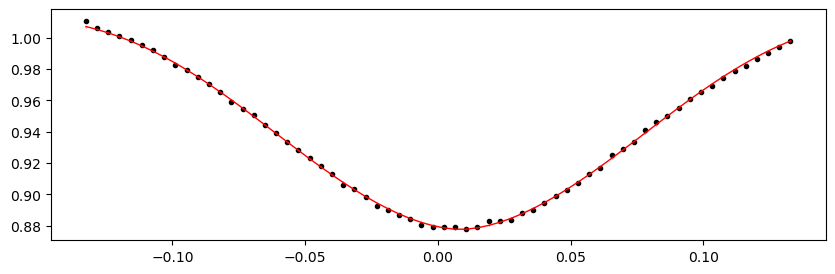

2879.0242233 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.30it/s]


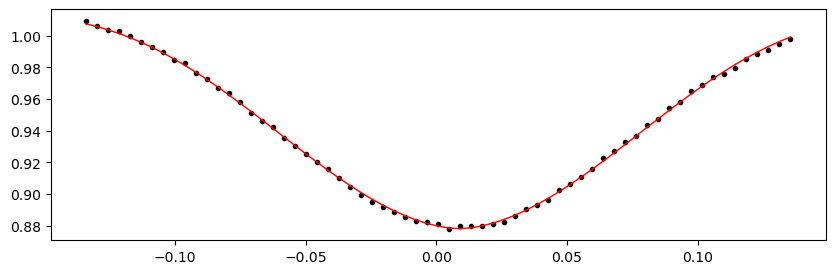

2879.353896 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.66it/s]


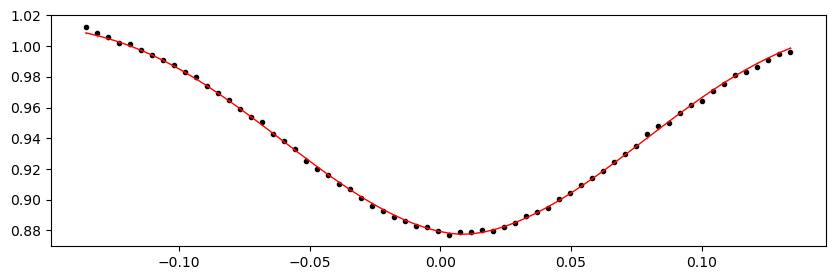

2879.6835687000003 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.94it/s]


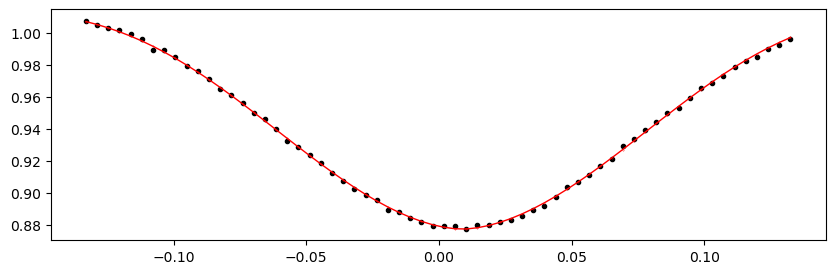

2880.0132414 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.48it/s]


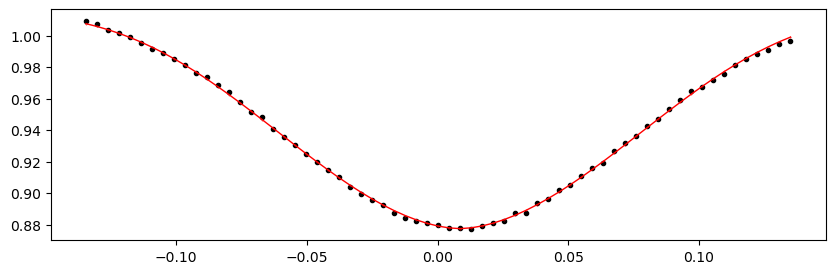

2880.3429140999997 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.70it/s]


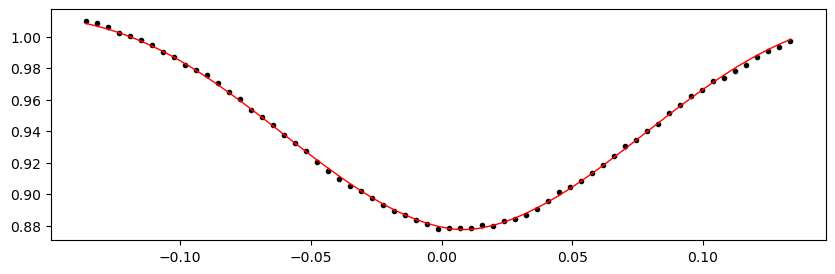

2880.6725868 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.40it/s]


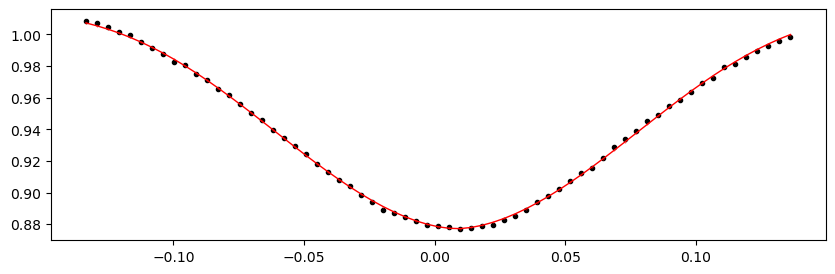

2881.0022595 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.06it/s]


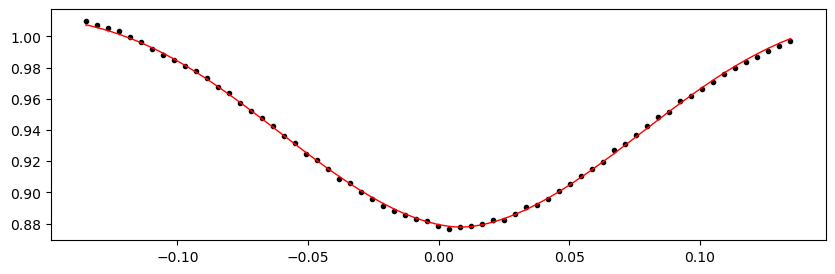

2881.3319321999998 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.25it/s]


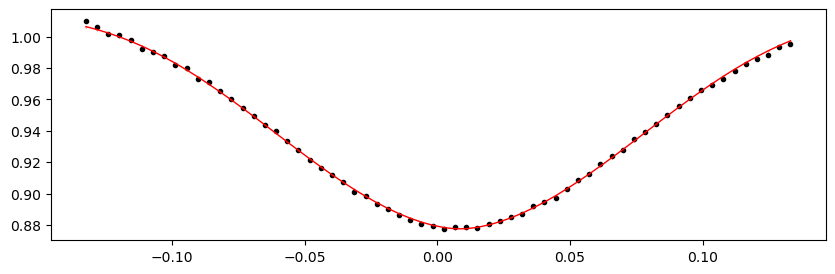

2881.6616049 1.0148412739248864 -0.1382231493062348 0.2312342989509577


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.27it/s]


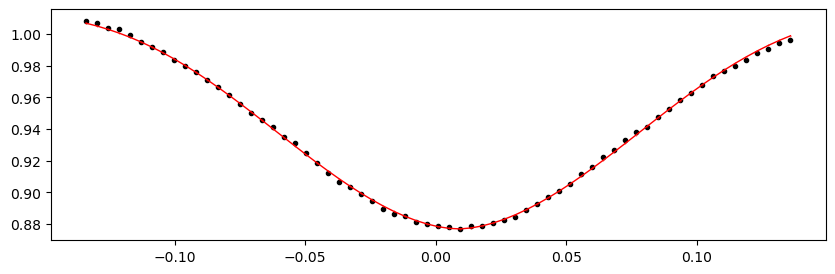

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has 

100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.38it/s]


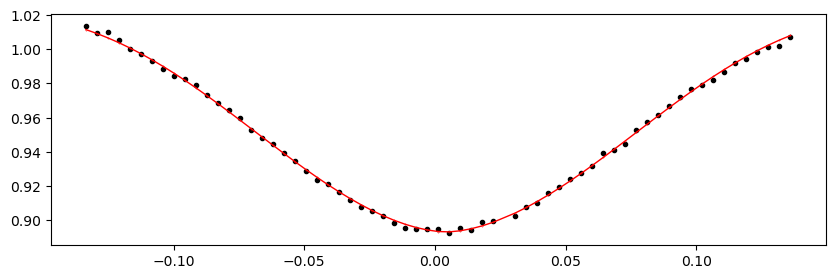

1783.35700485 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.55it/s]


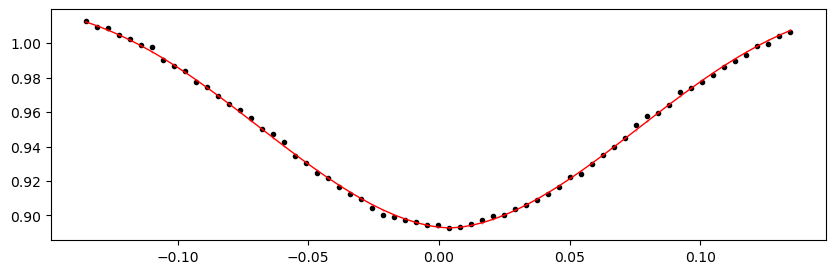

1783.68667755 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.71it/s]


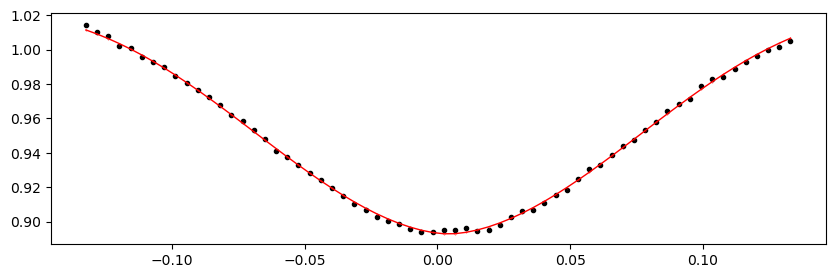

1784.0163502500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.84it/s]


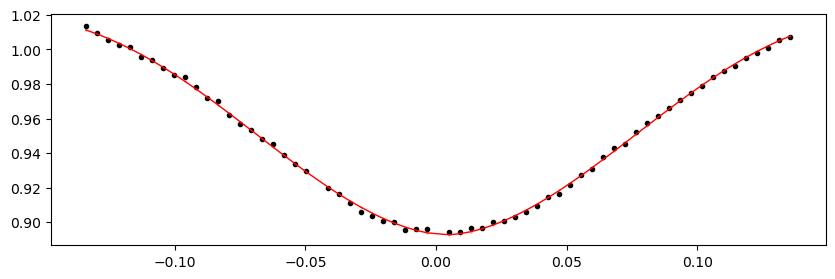

1784.3460229500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.59it/s]


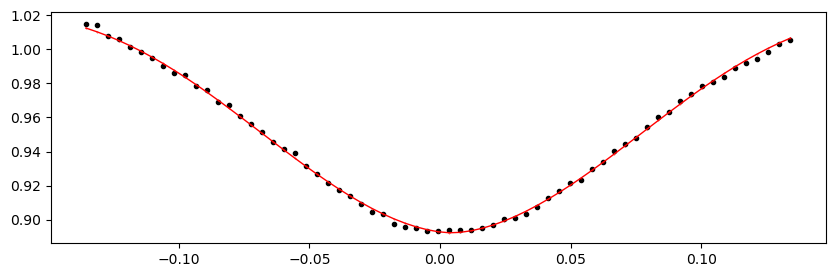

1784.67569565 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.57it/s]


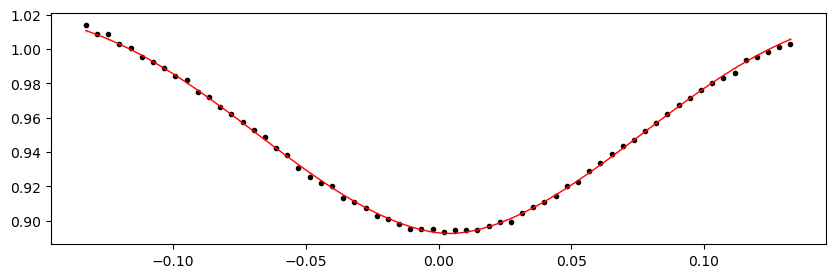

1785.00536835 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.93it/s]


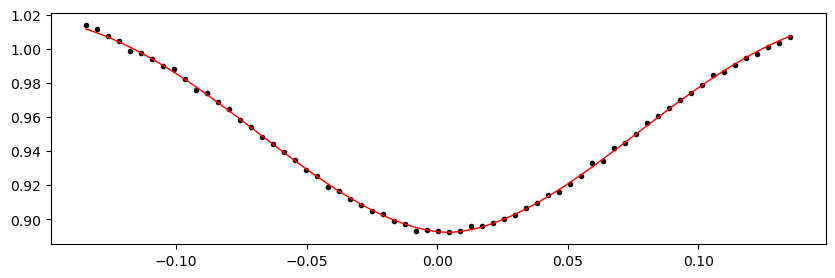

1785.3350410500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.40it/s]


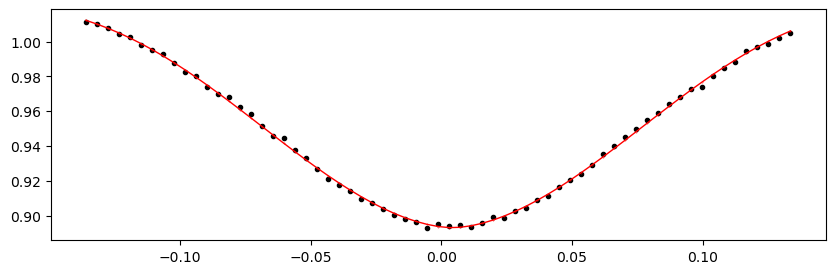

1785.6647137500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.18it/s]


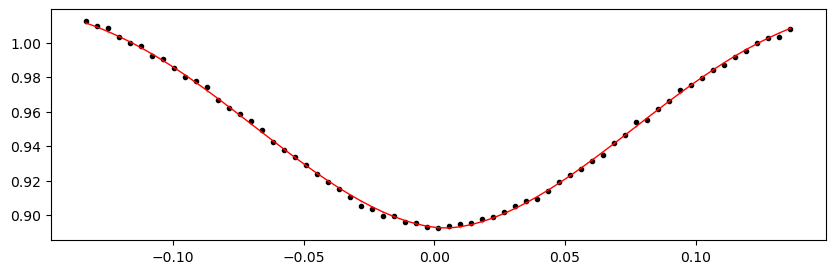

1785.99438645 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.83it/s]


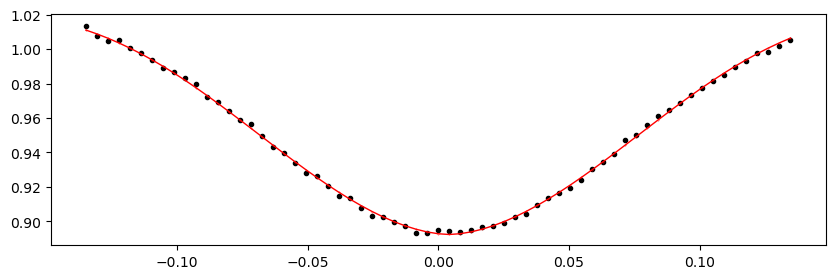

1786.32405915 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.27it/s]


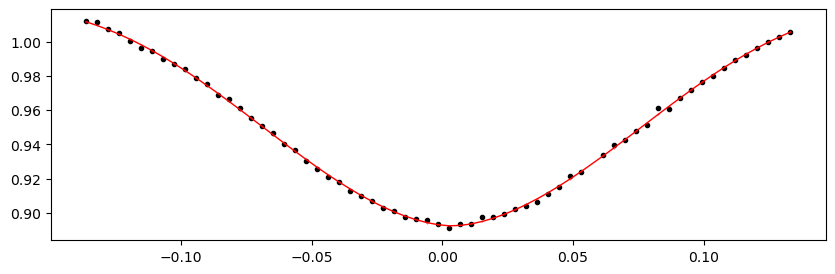

1786.6537318500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.01it/s]


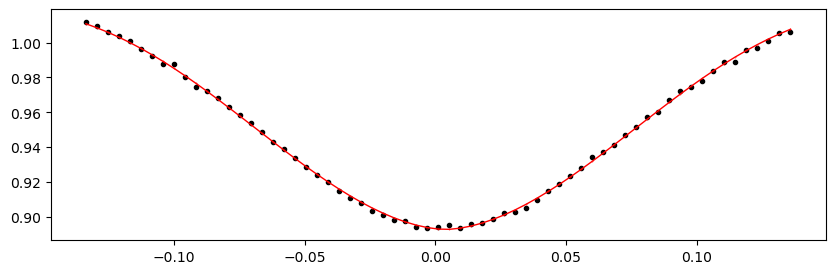

1786.9834045500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.85it/s]


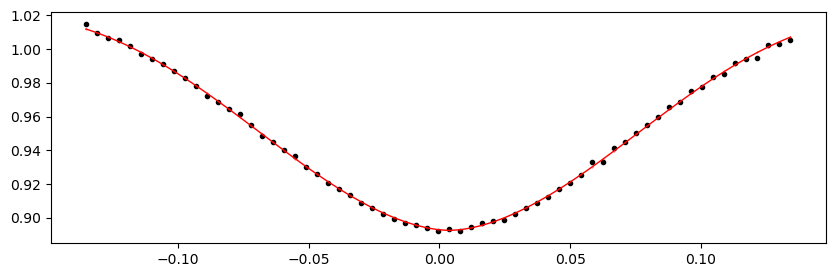

1787.31307725 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.53it/s]


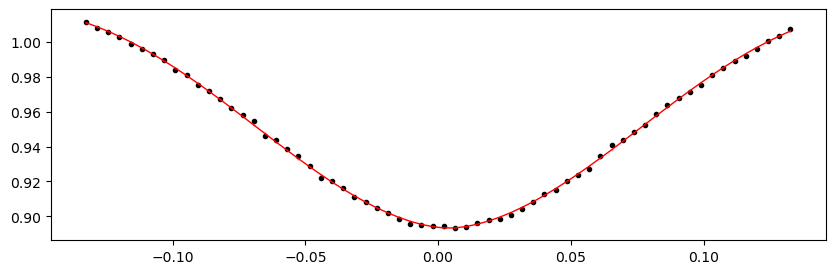

1787.64274995 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.83it/s]


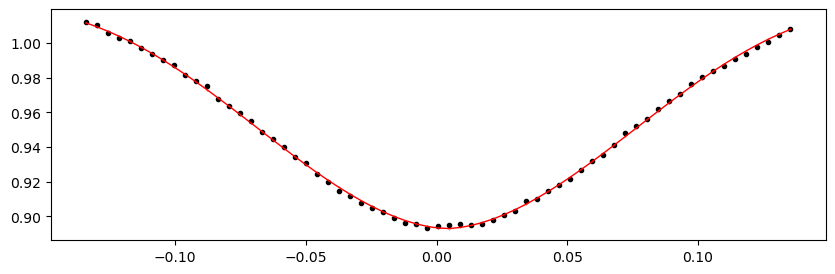

1787.97242265 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.11it/s]


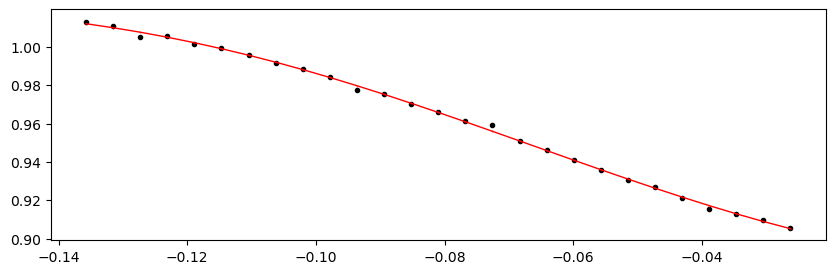

2853.47458905 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.36it/s]


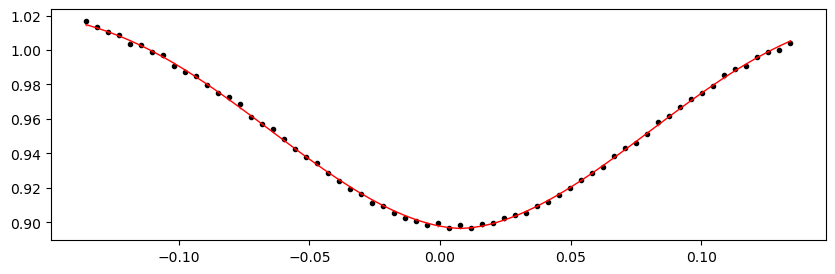

2853.80426175 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.01it/s]


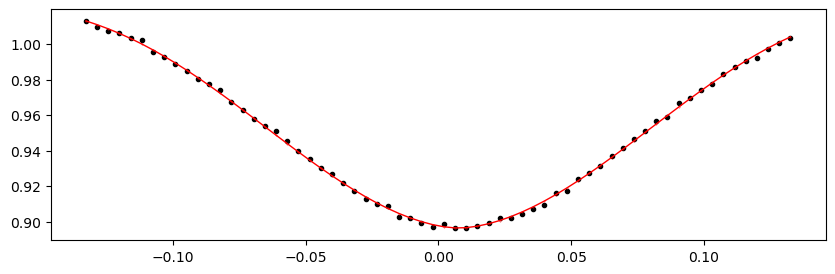

2854.13393445 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.82it/s]


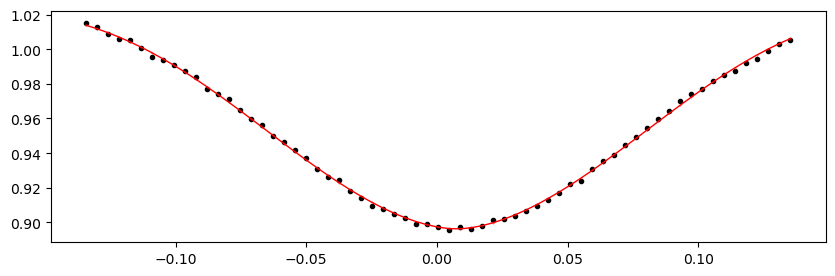

2854.46360715 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.52it/s]


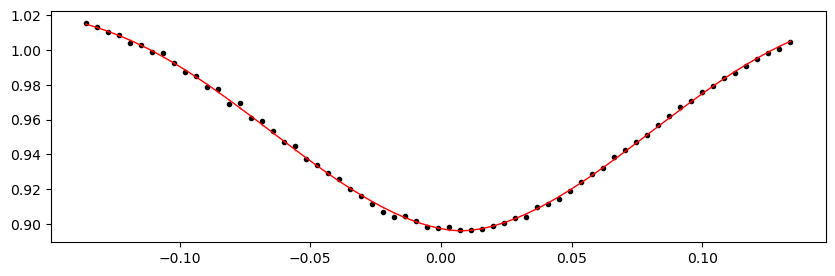

2854.79327985 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.27it/s]


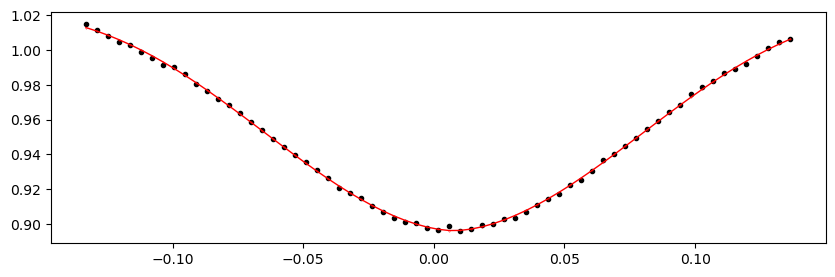

2855.1229525500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.31it/s]


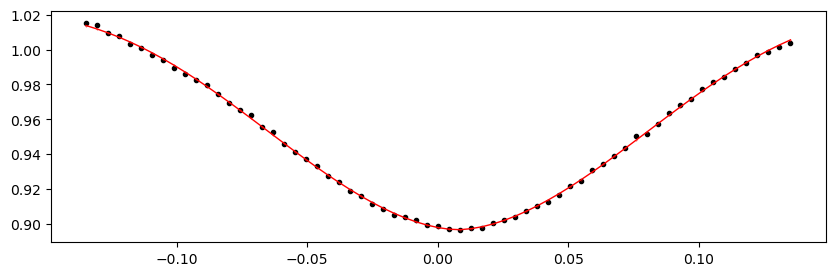

2855.45262525 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.11it/s]


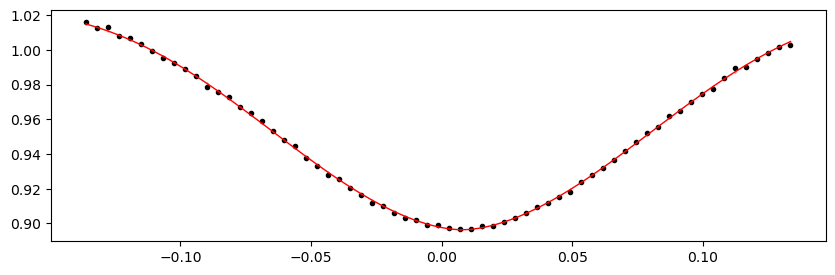

2855.78229795 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.41it/s]


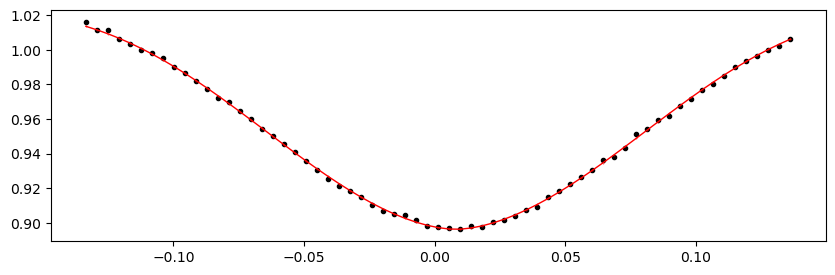

2856.1119706500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.43it/s]


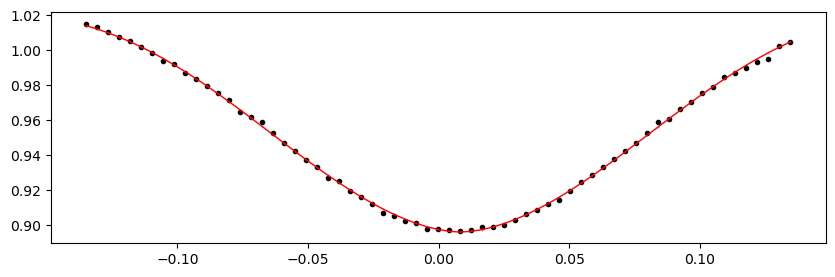

2856.44164335 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.39it/s]


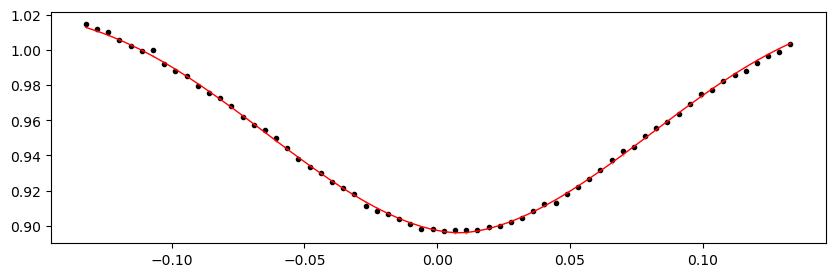

2856.7713160499998 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.75it/s]


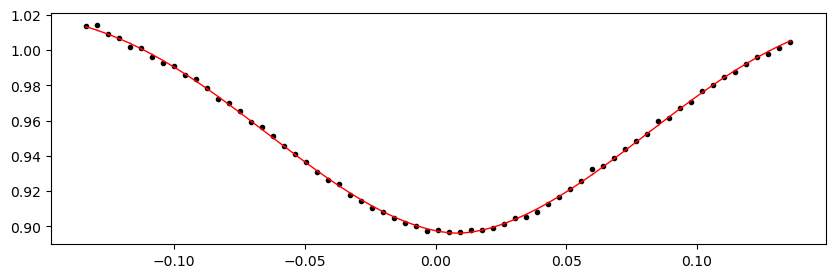

2857.1009887500004 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.14it/s]


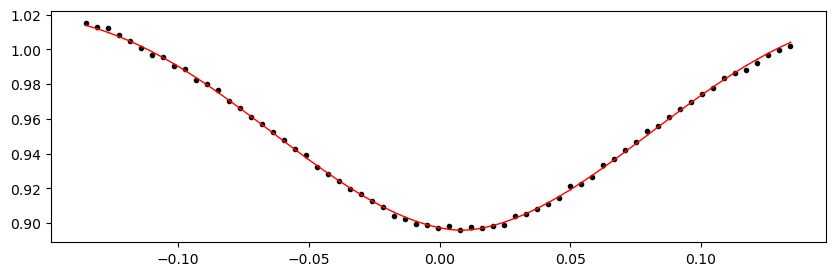

2857.43066145 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.38it/s]


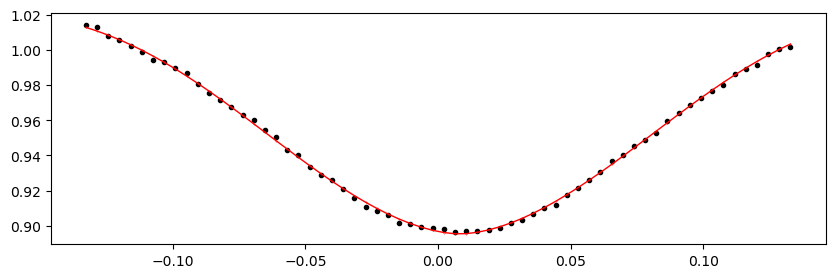

2857.76033415 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.63it/s]


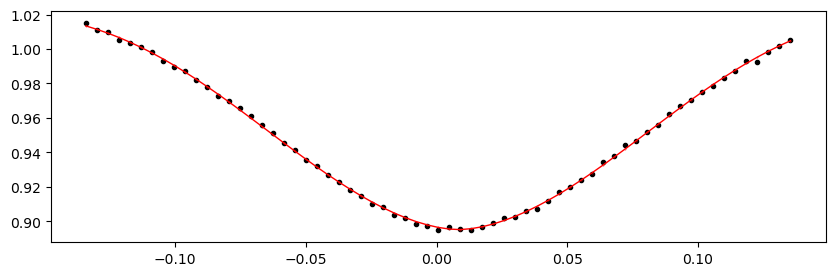

2858.09000685 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.20it/s]


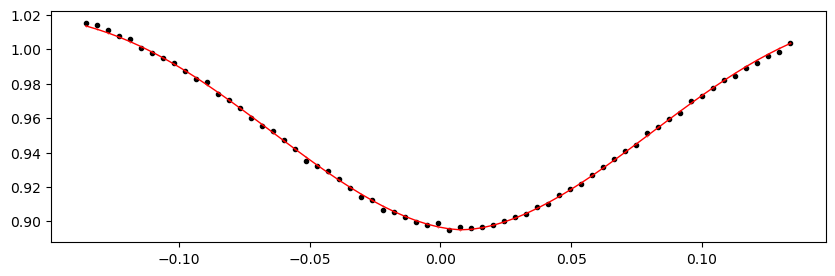

2858.41967955 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.76it/s]


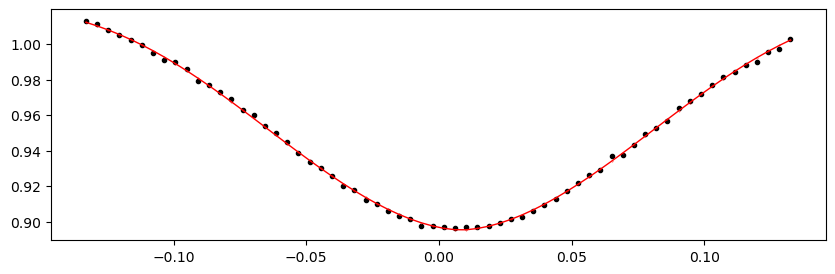

2858.74935225 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.99it/s]


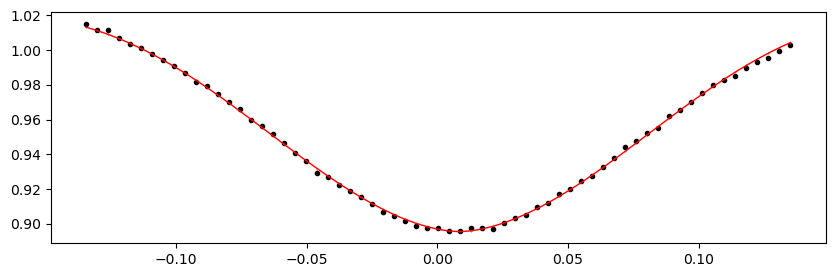

2859.07902495 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.16it/s]


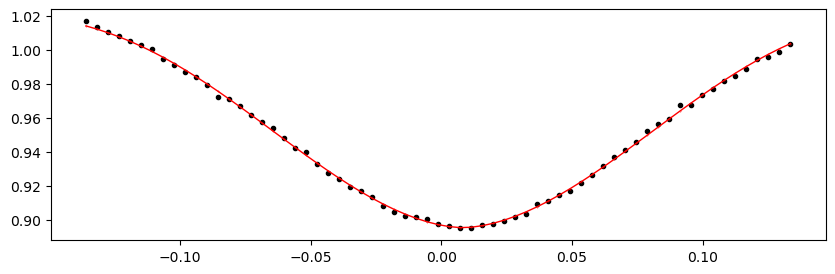

2859.4086976500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.16it/s]


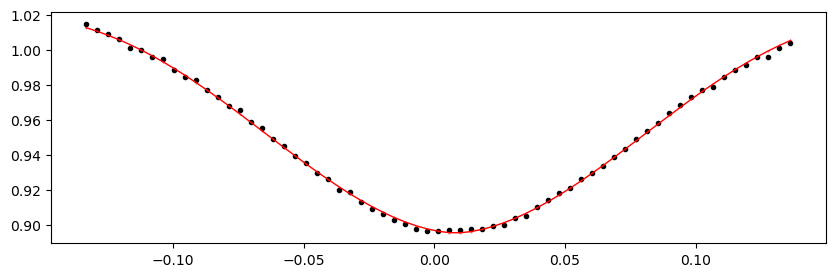

2859.73837035 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.16it/s]


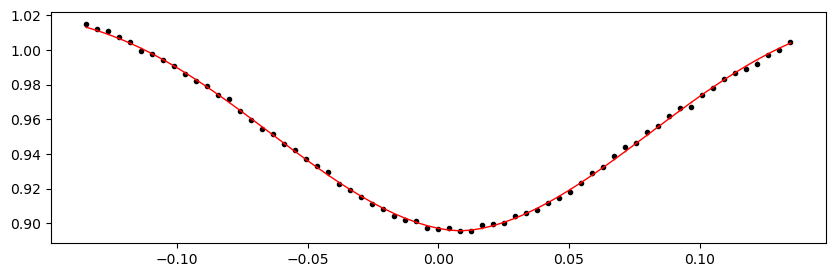

2860.06804305 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.82it/s]


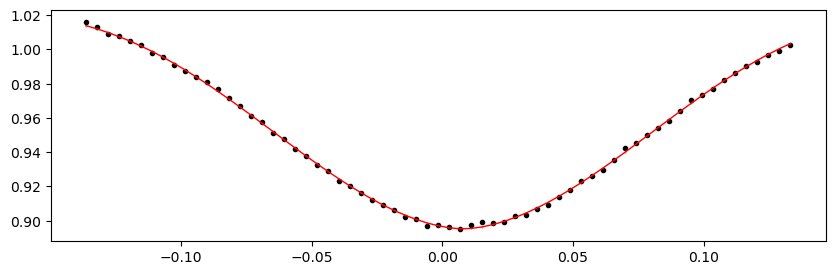

2860.3977157500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.11it/s]


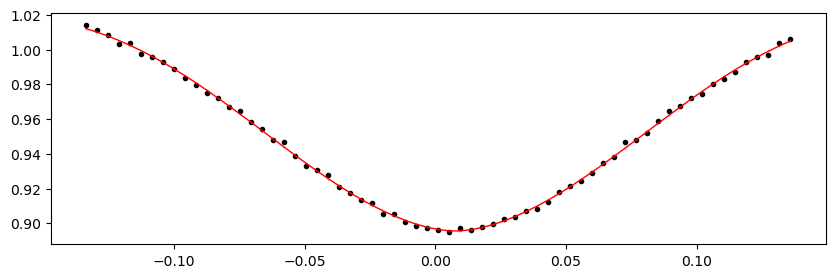

2861.0570611499998 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.20it/s]


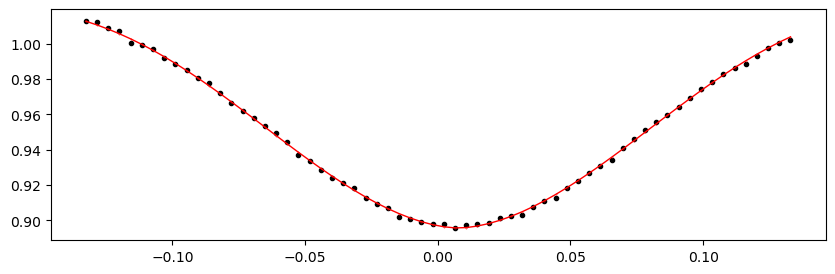

2861.3867338500004 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.63it/s]


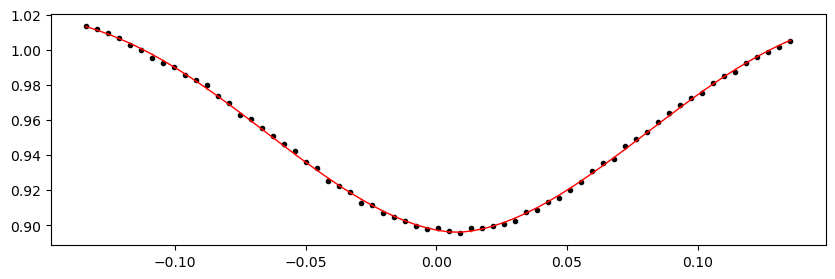

2861.71640655 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.65it/s]


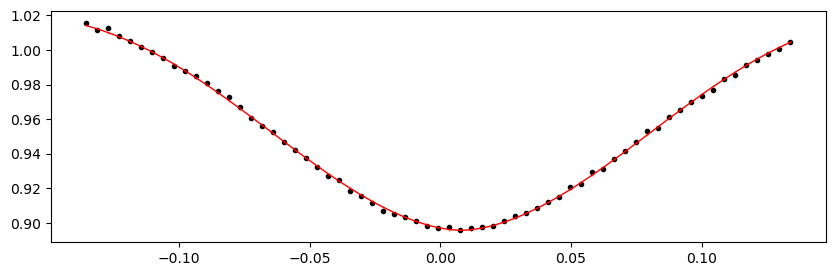

2862.04607925 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.01it/s]


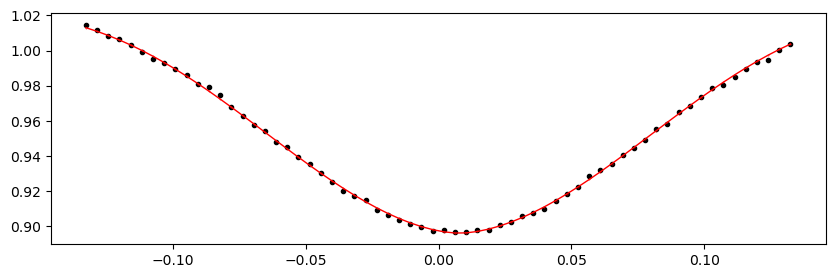

2862.37575195 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.57it/s]


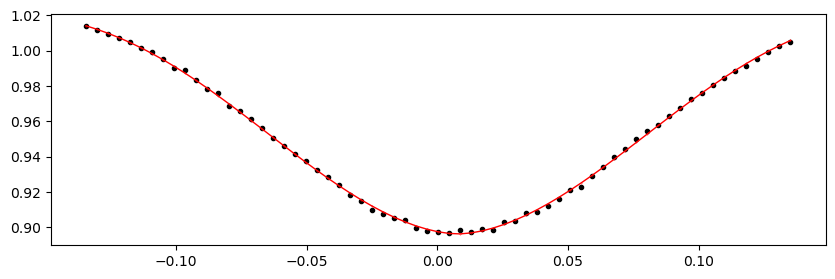

2862.70542465 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.03it/s]


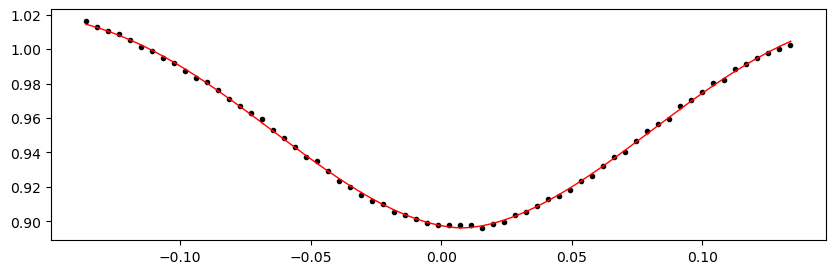

2863.03509735 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.60it/s]


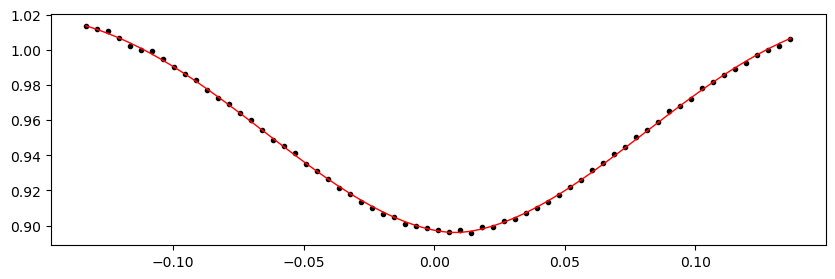

2866.66149705 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.60it/s]


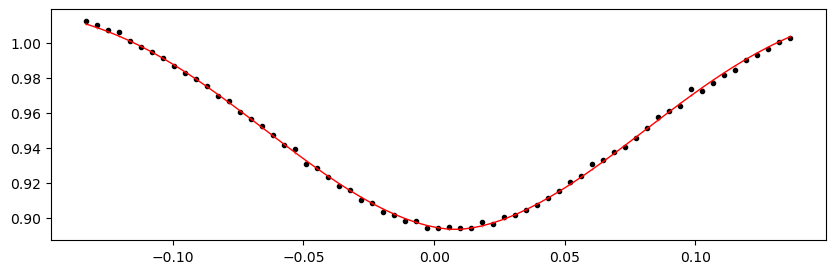

2866.99116975 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.88it/s]


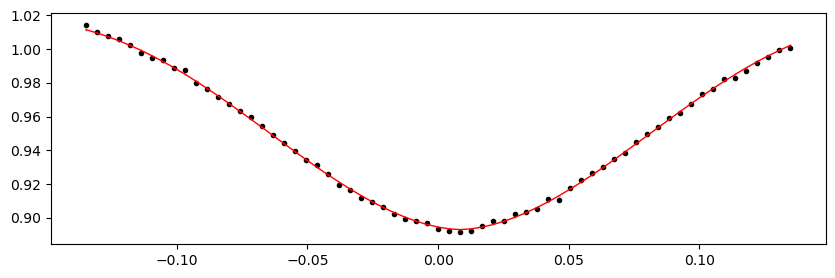

2867.65051515 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.35it/s]


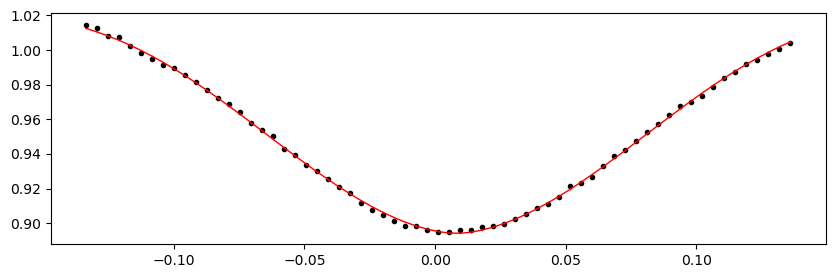

2867.98018785 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.75it/s]


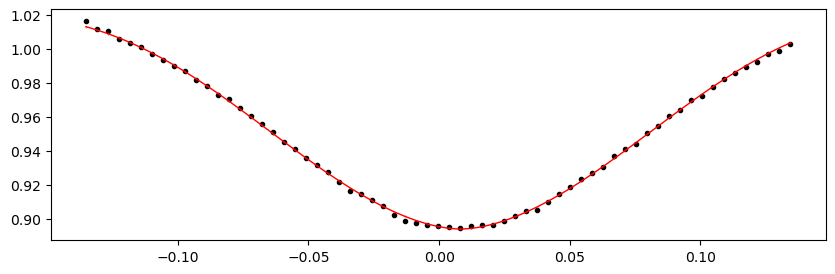

2868.30986055 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.63it/s]


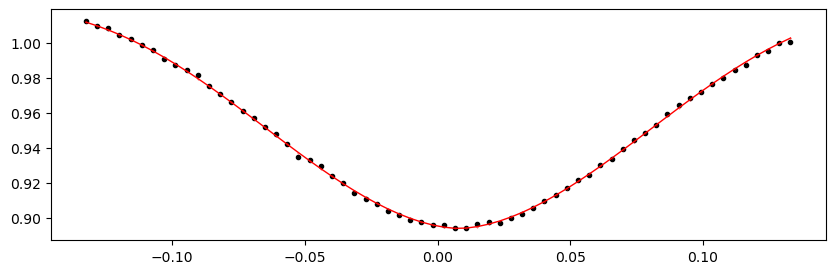

2868.63953325 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.74it/s]


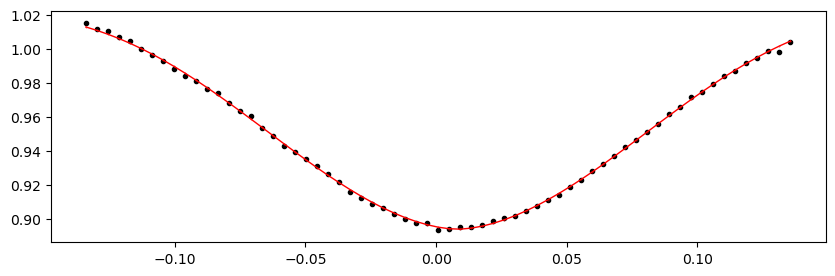

2868.9692059500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.23it/s]


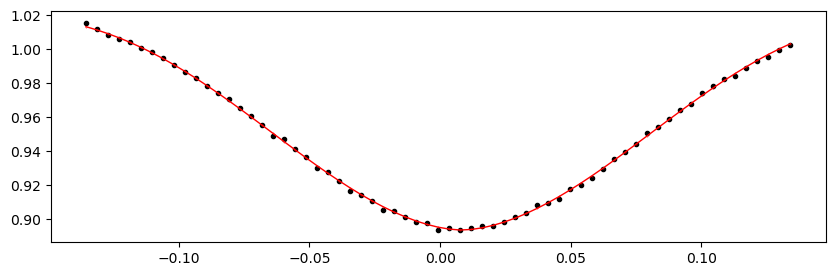

2869.29887865 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.11it/s]


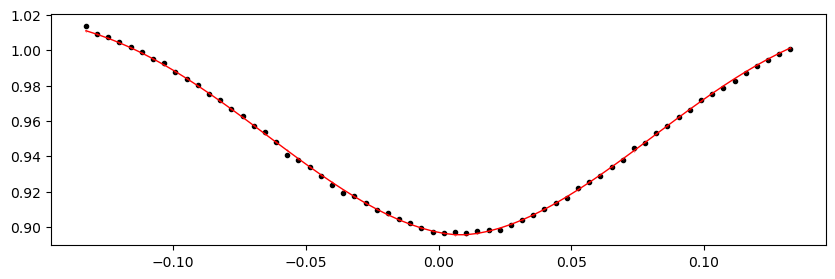

2869.6285513499997 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.79it/s]


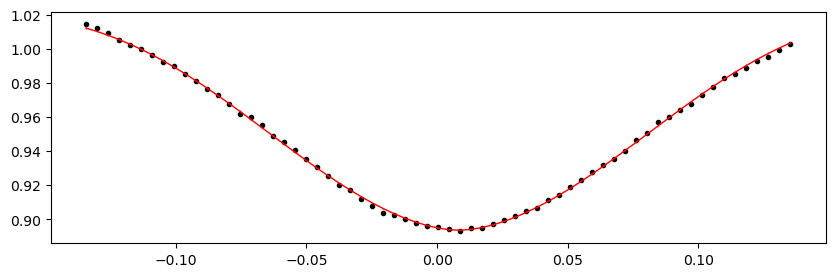

2869.9582240500004 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.37it/s]


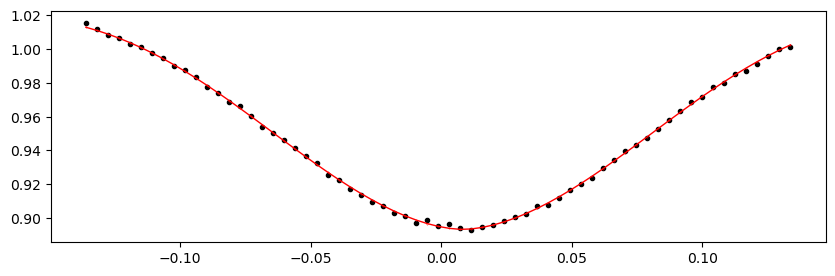

2870.28789675 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.45it/s]


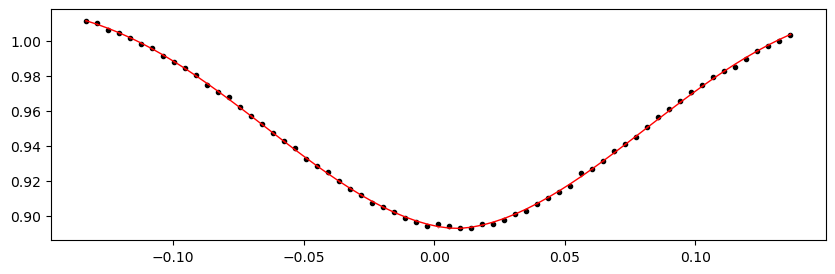

2870.61756945 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.87it/s]


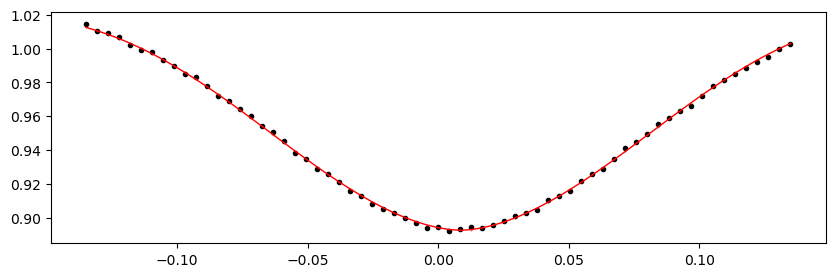

2870.94724215 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.51it/s]


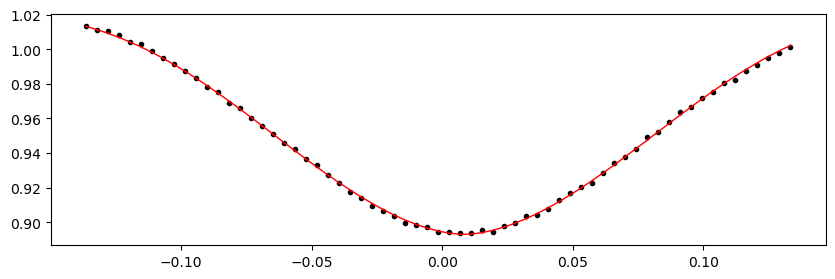

2871.27691485 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.12it/s]


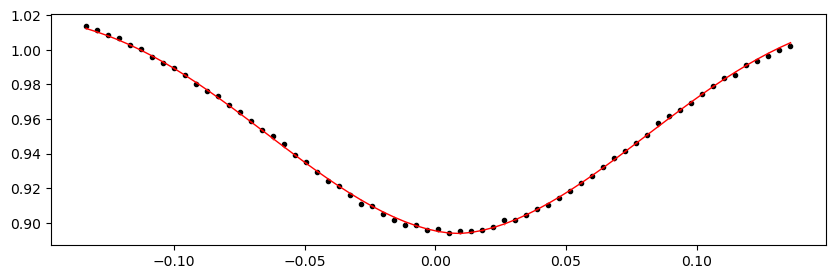

2871.60658755 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.89it/s]


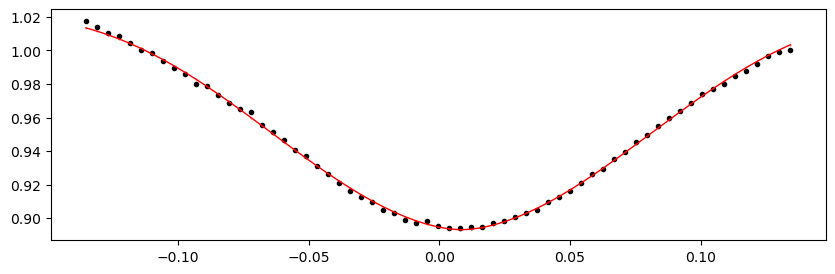

2871.93626025 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.82it/s]


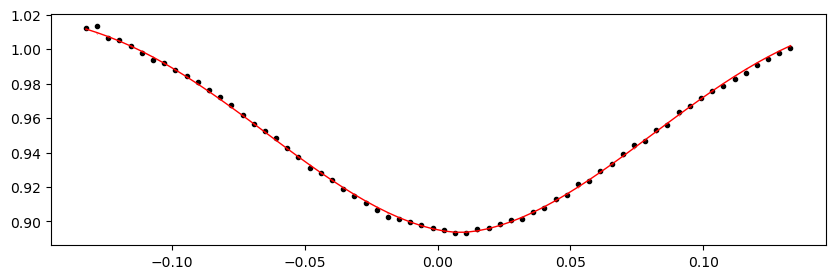

2872.26593295 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.67it/s]


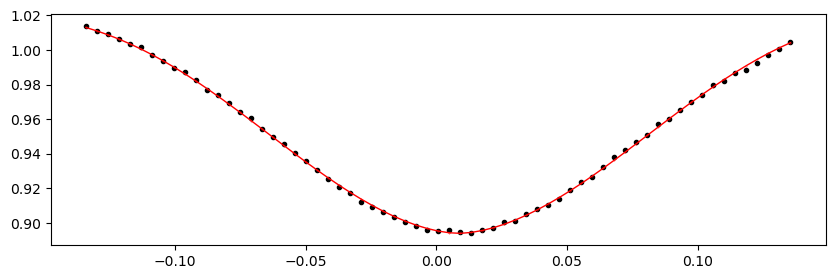

2872.59560565 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.80it/s]


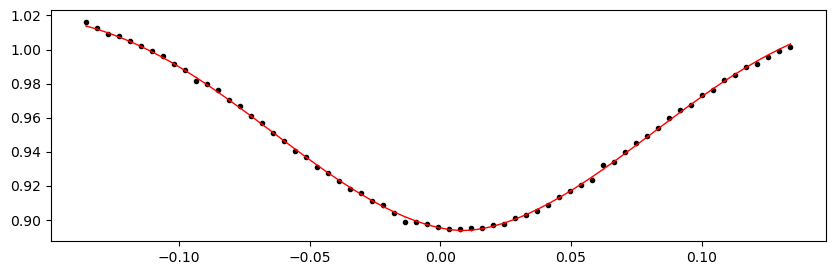

2872.92527835 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.24it/s]


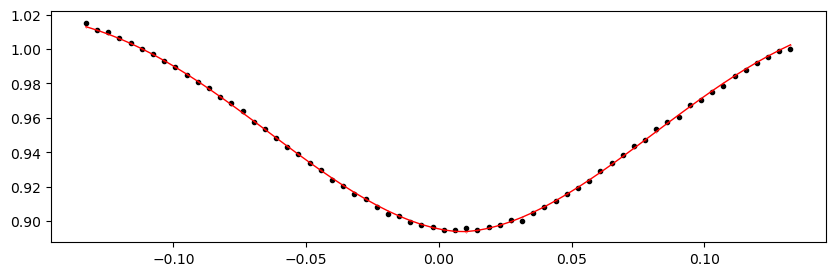

2873.2549510500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.86it/s]


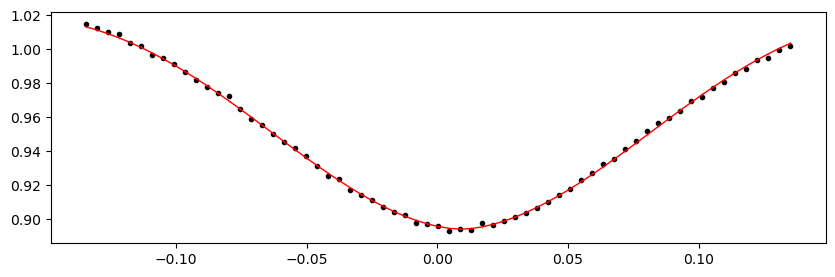

2873.58462375 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.27it/s]


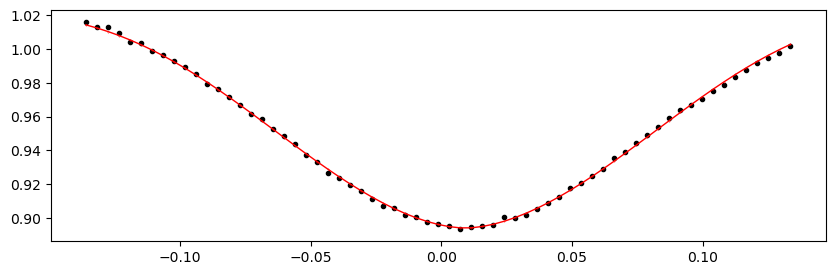

2873.91429645 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.77it/s]


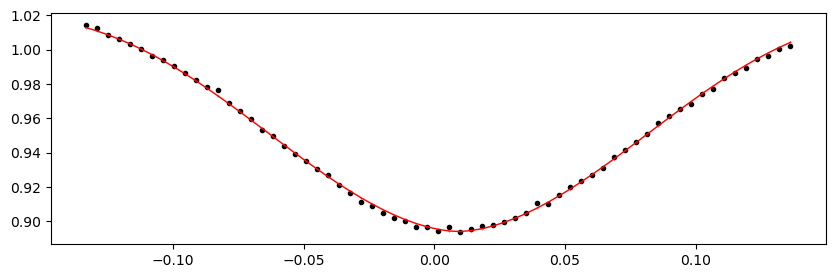

2874.2439691500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.25it/s]


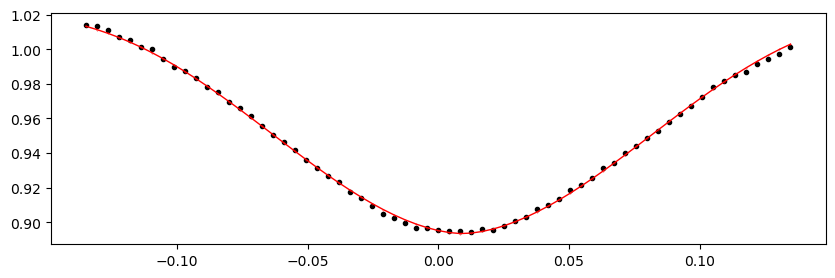

2874.57364185 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.90it/s]


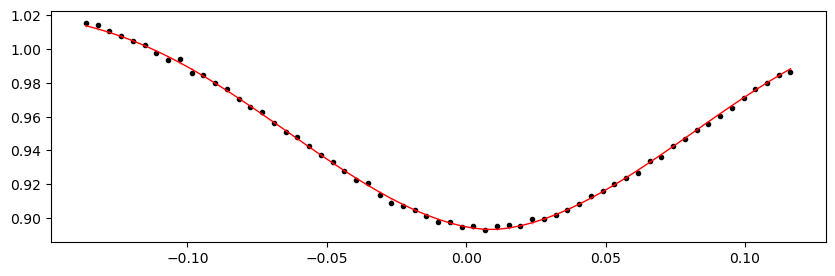

2874.90331455 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.00it/s]


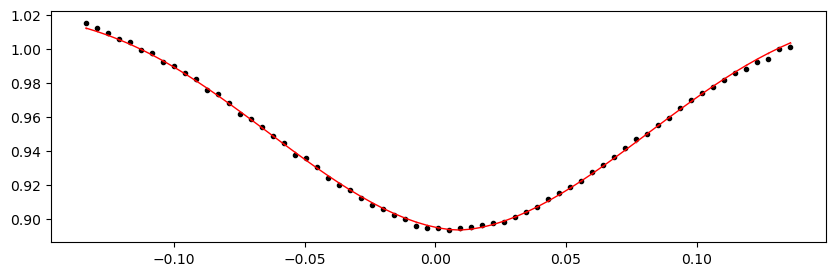

2875.23298725 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.59it/s]


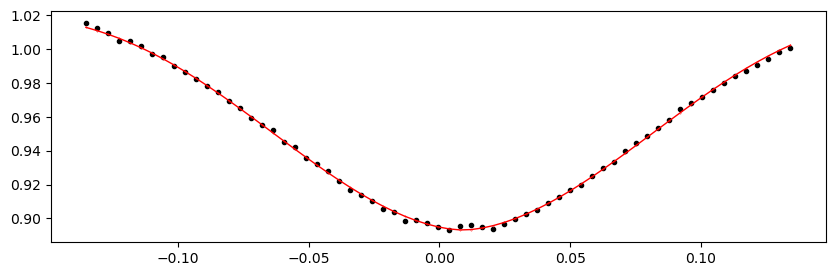

2875.56265995 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.82it/s]


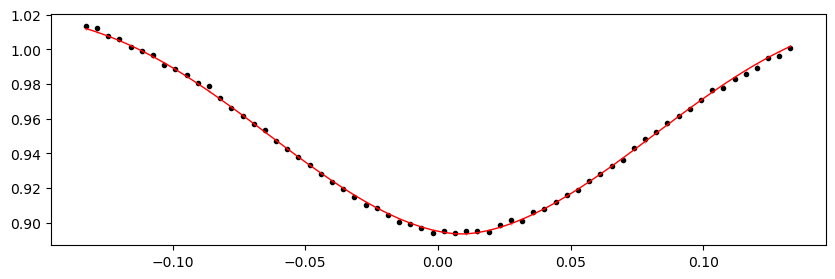

2875.89233265 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.97it/s]


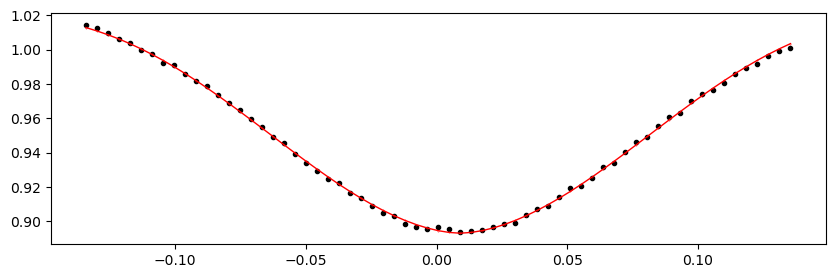

2876.22200535 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.56it/s]


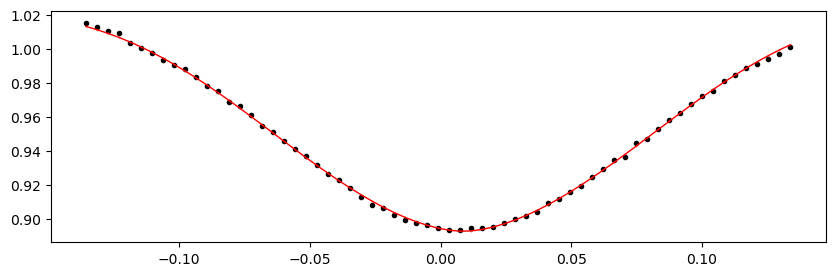

2876.55167805 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.56it/s]


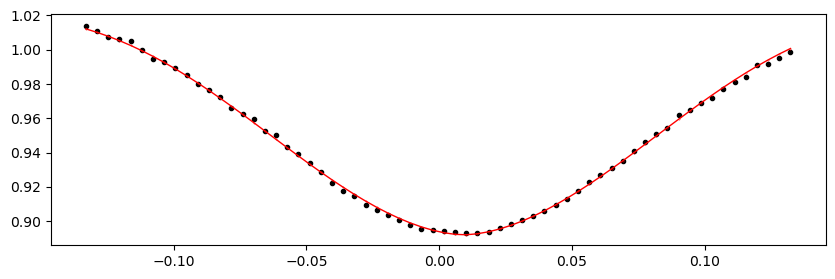

2876.88135075 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.08it/s]


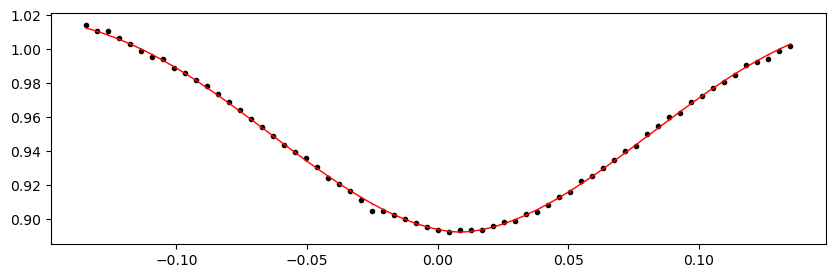

2877.21102345 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.39it/s]


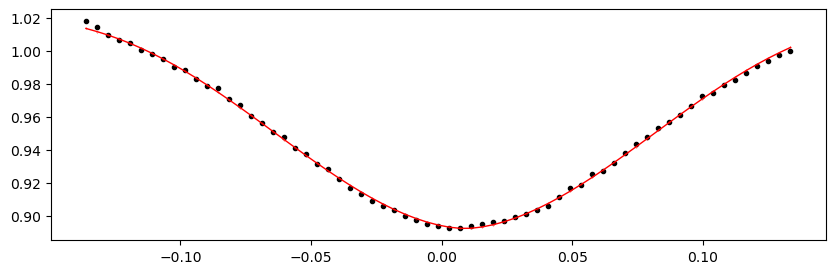

2877.5406961500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.05it/s]


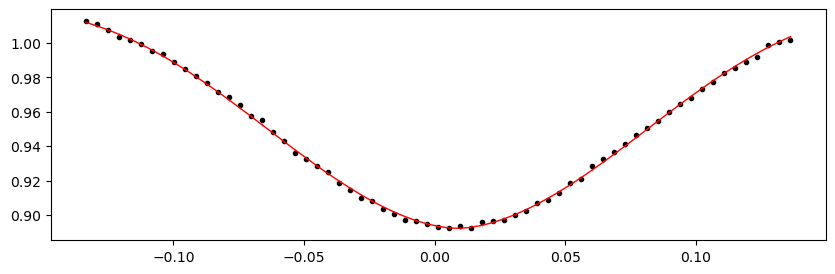

2877.87036885 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.34it/s]


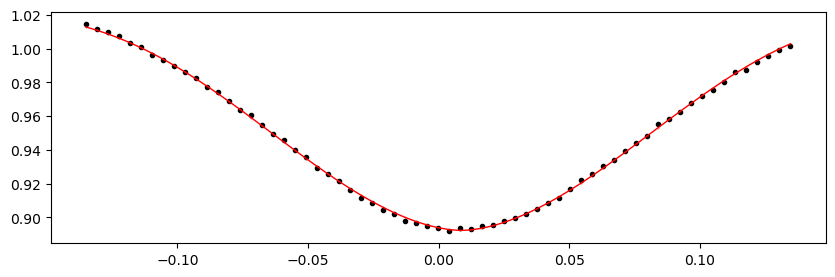

2878.20004155 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.26it/s]


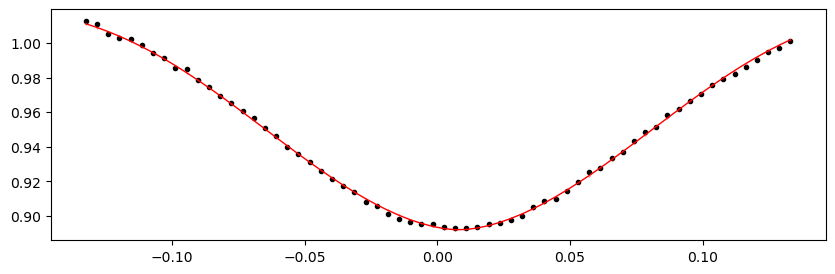

2878.5297142500003 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.91it/s]


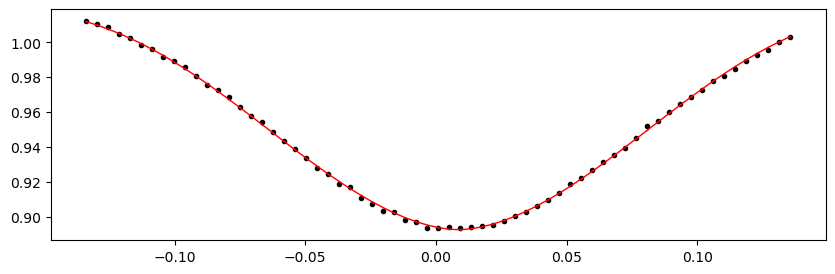

2878.85938695 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.29it/s]


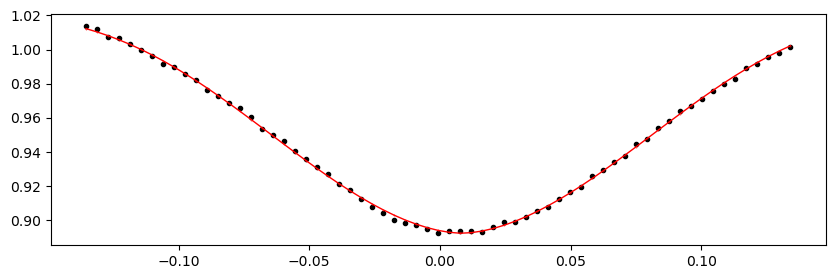

2879.1890596499998 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.66it/s]


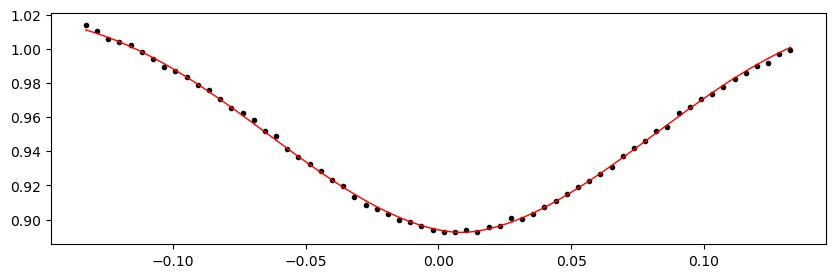

2879.5187323500004 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.76it/s]


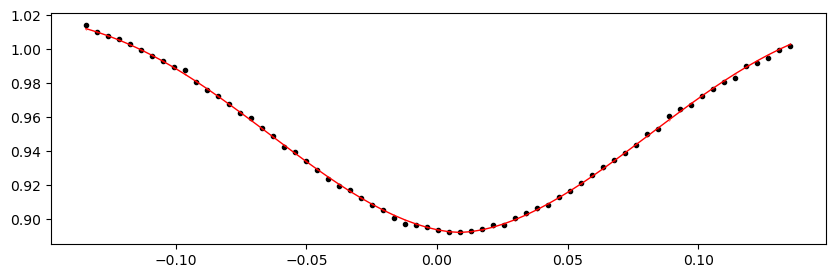

2879.84840505 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.76it/s]


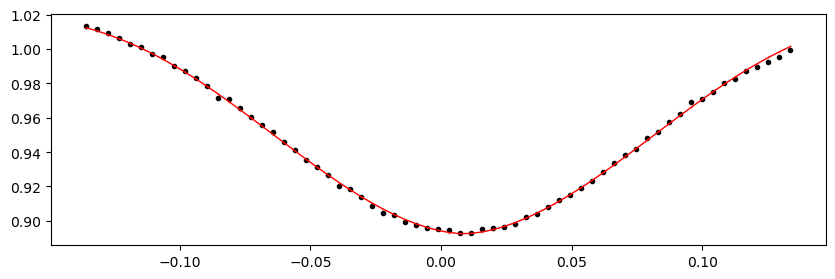

2880.17807775 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.66it/s]


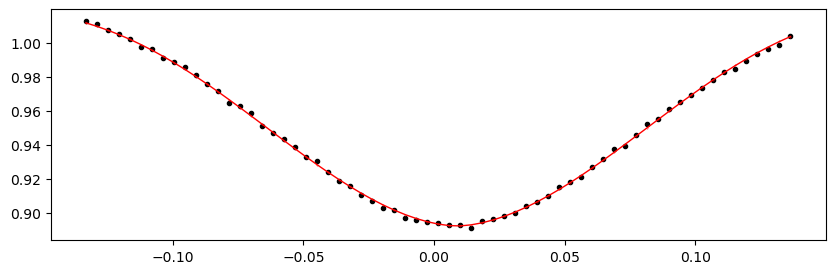

2880.50775045 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.06it/s]


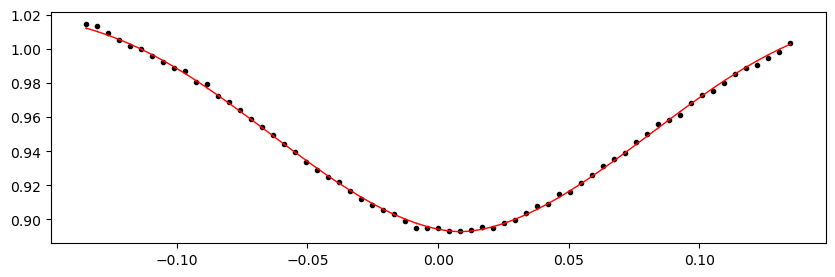

2880.83742315 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.59it/s]


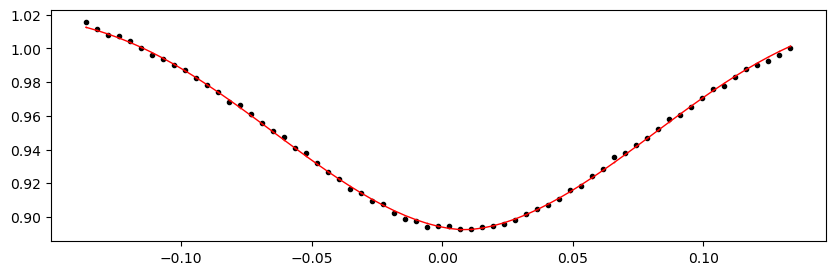

2881.16709585 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.03it/s]


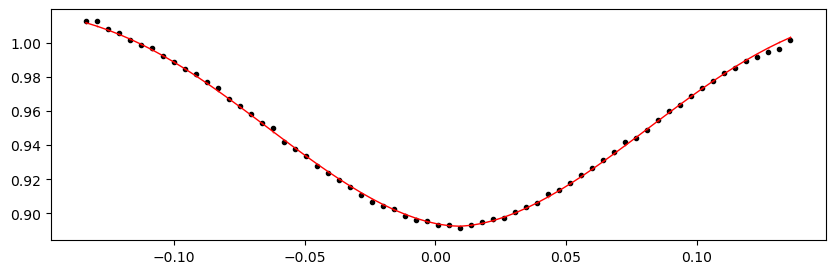

2881.49676855 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.32it/s]


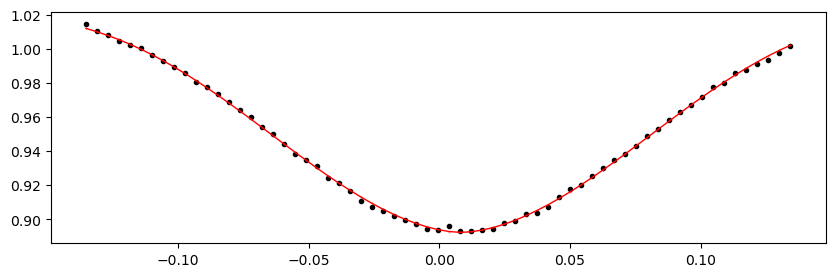

2881.8264412500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.60it/s]


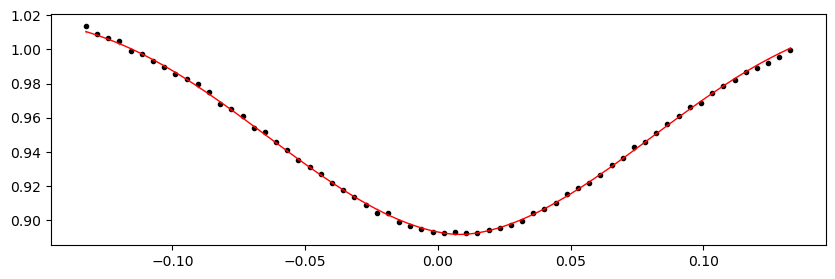

In [54]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
1764.89533365 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.54it/s]


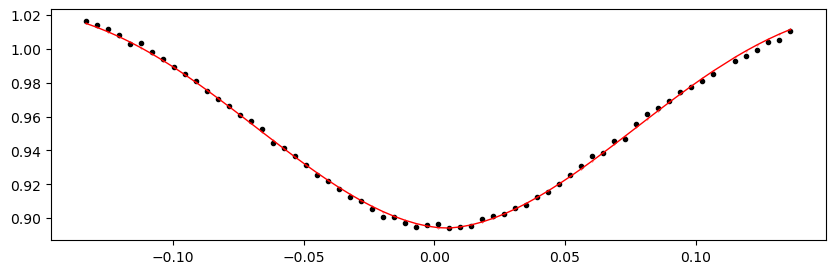

1765.22500635 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.58it/s]


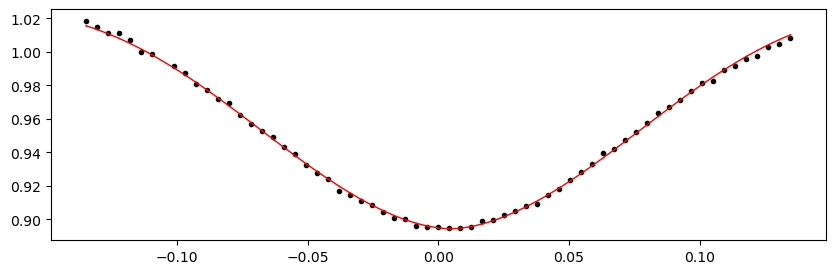

1765.55467905 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.67it/s]


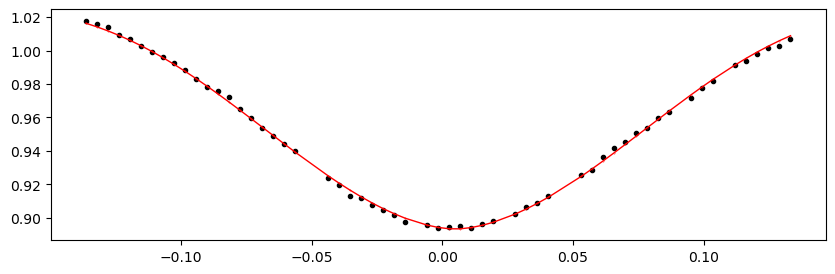

1765.8843517500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.41it/s]


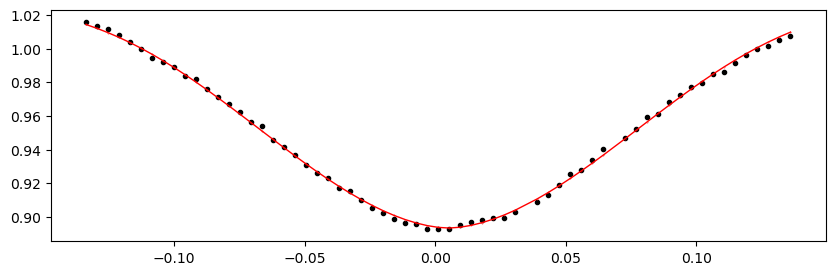

1766.2140244500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.82it/s]


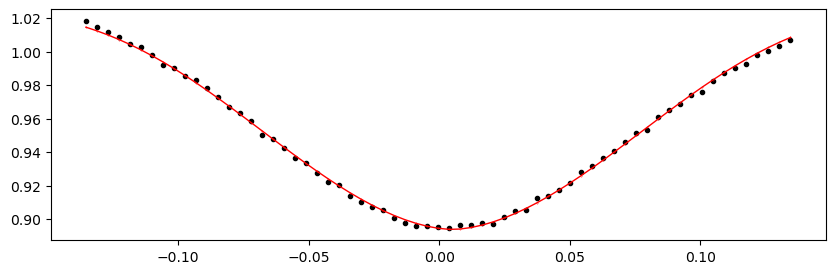

1766.54369715 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.05it/s]


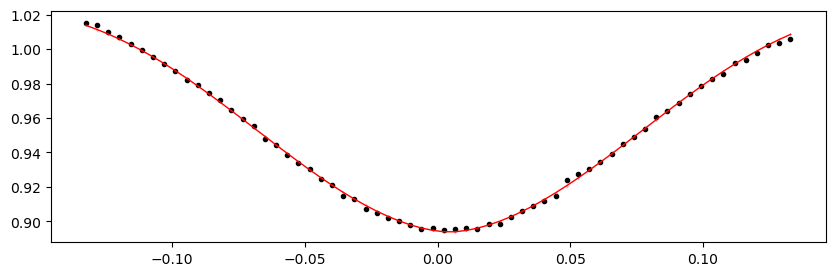

1766.87336985 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.14it/s]


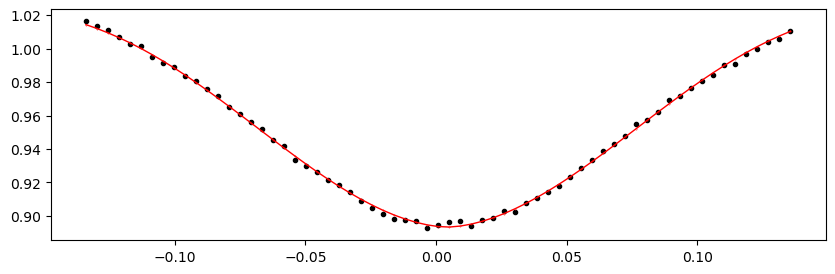

1767.2030425500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.83it/s]


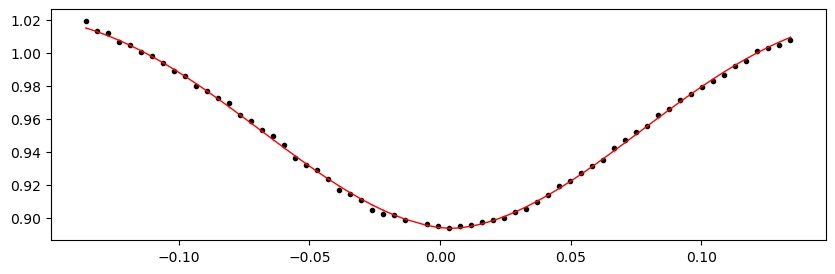

1767.5327152500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.52it/s]


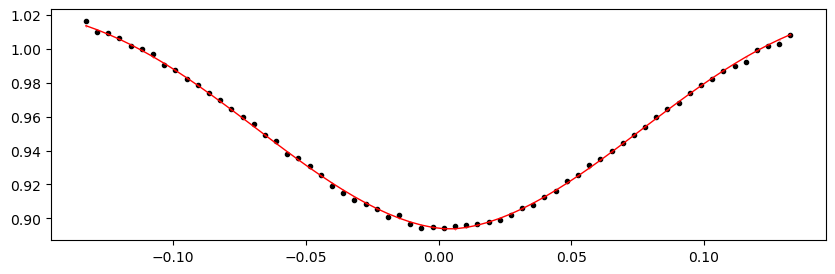

1767.86238795 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.32it/s]


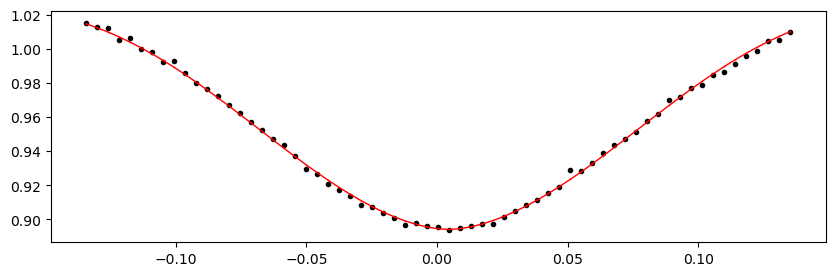

1768.19206065 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.61it/s]


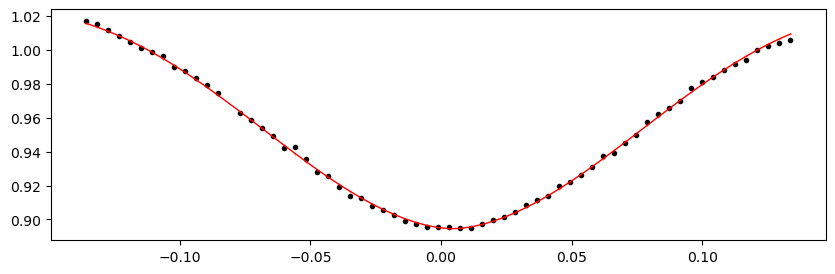

1768.5217333500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.18it/s]


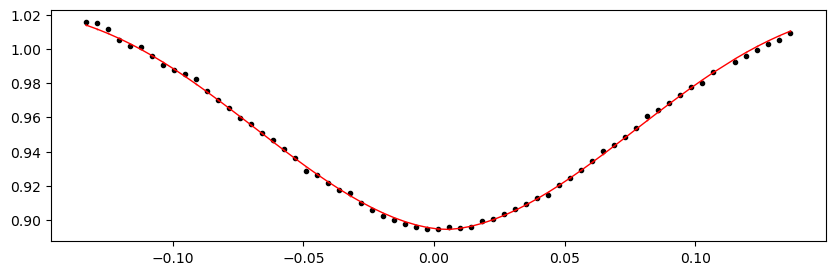

1768.8514060500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.23it/s]


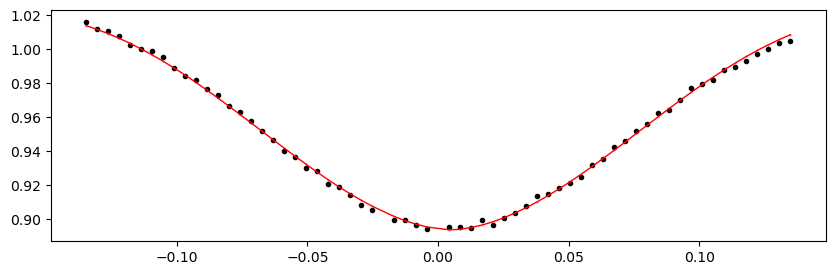

1769.18107875 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.85it/s]


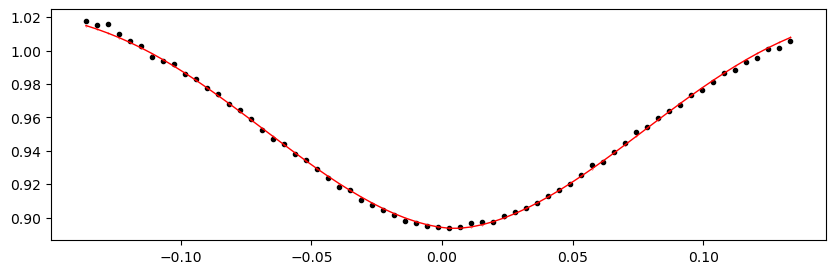

1769.51075145 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.91it/s]


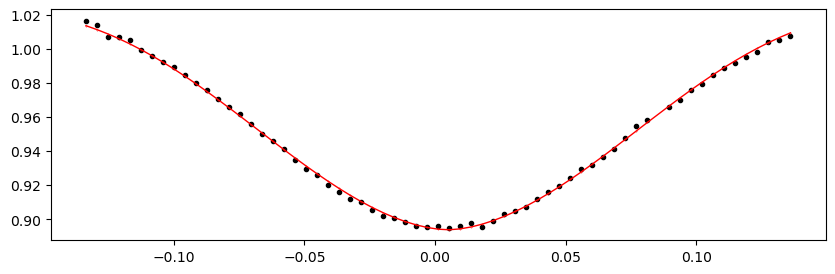

1769.8404241500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.65it/s]


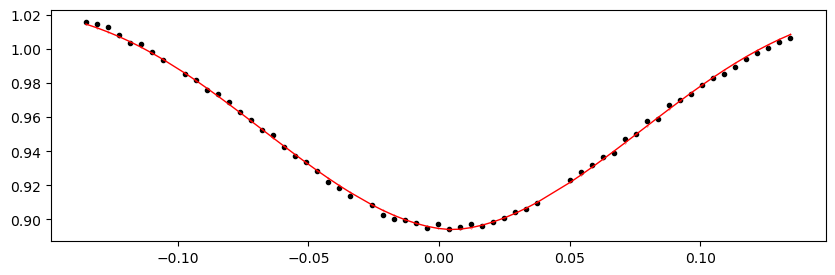

1770.1700968500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.72it/s]


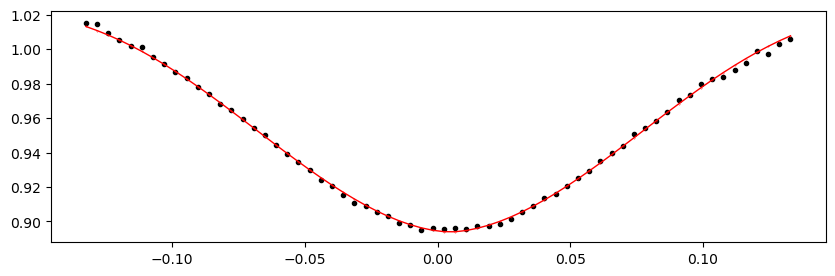

1770.49976955 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.46it/s]


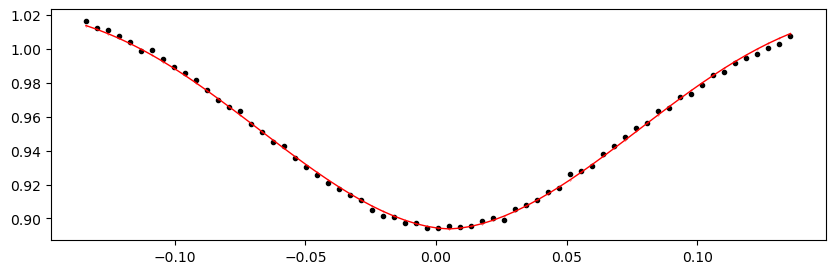

1770.82944225 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.39it/s]


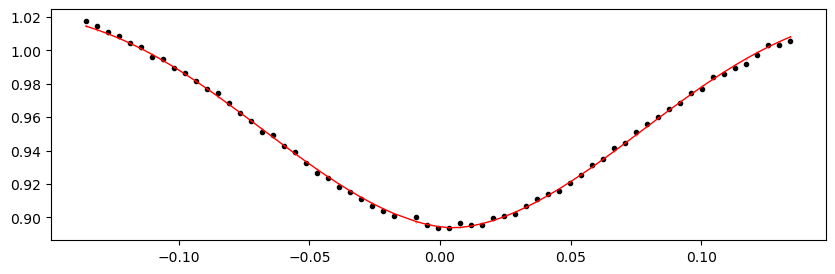

1771.15911495 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.94it/s]


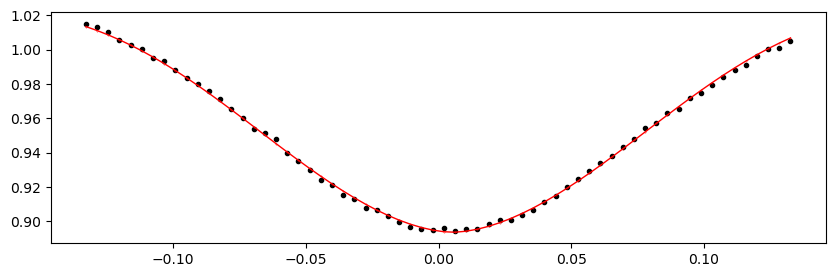

1771.4887876500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.42it/s]


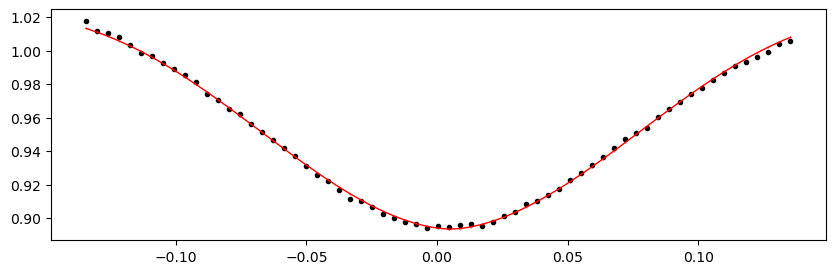

1771.8184603500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.84it/s]


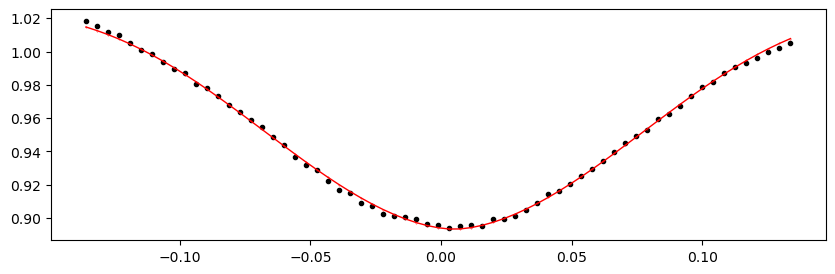

1772.14813305 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.71it/s]


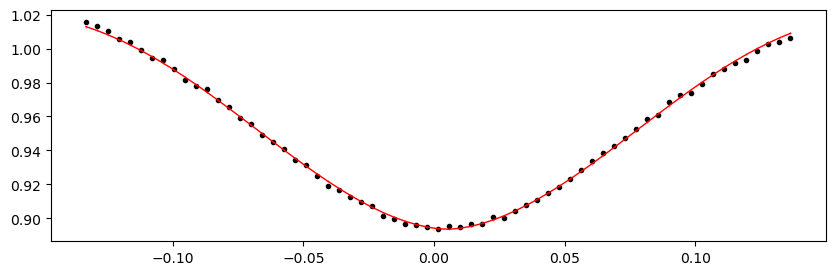

1772.47780575 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.09it/s]


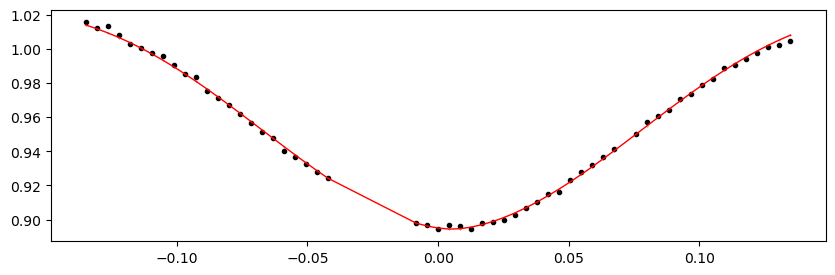

1772.8074784500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.95it/s]


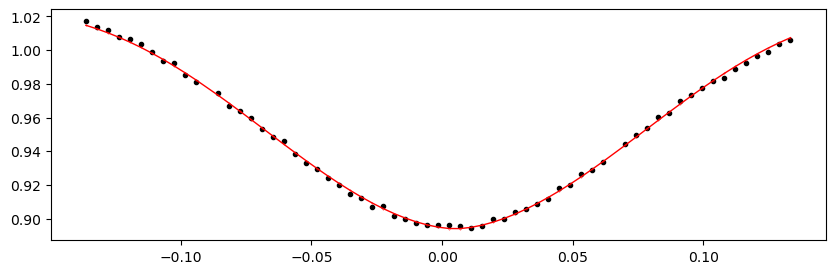

1777.75256895 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.81it/s]


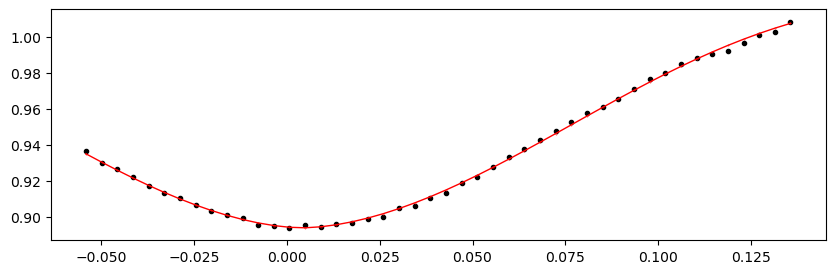

1778.08224165 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.25it/s]


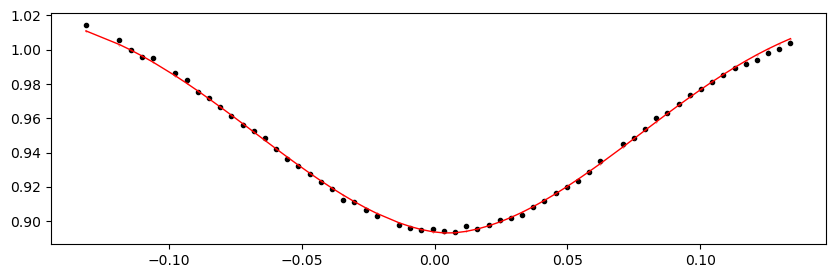

1778.4119143500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.90it/s]


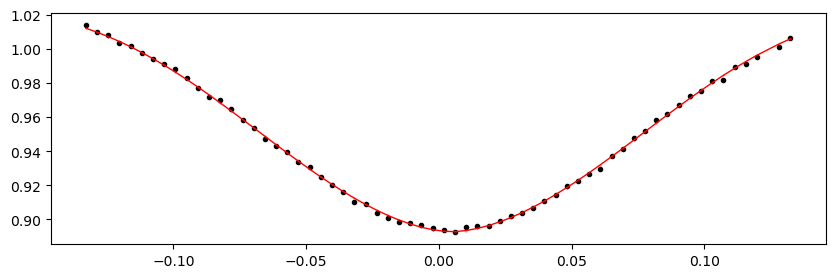

1778.7415870500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.60it/s]


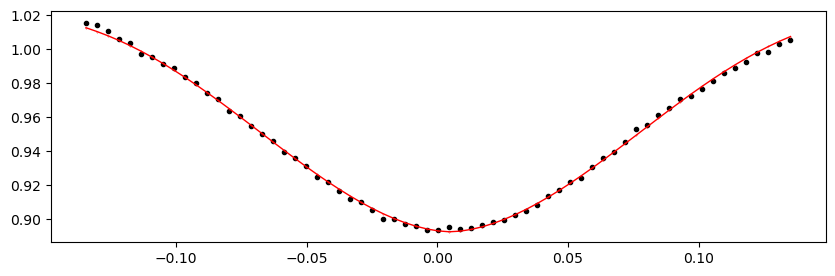

1779.07125975 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.72it/s]


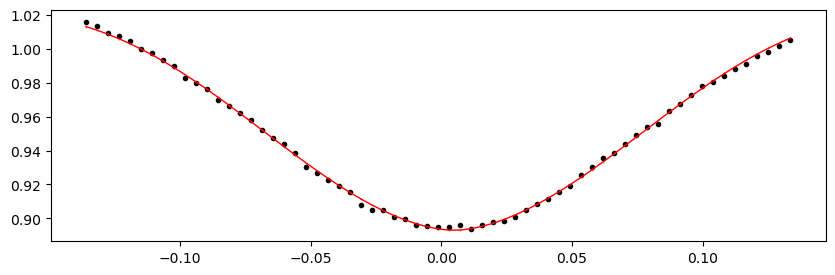

1779.40093245 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.75it/s]


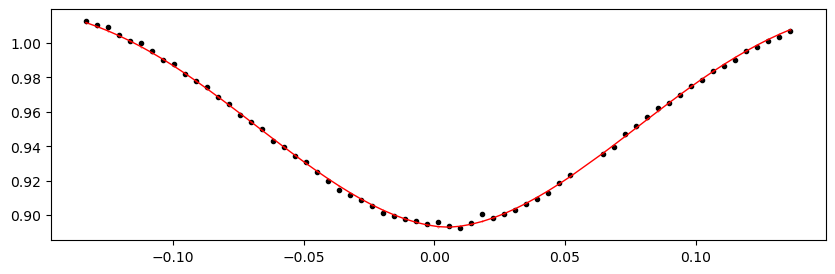

1779.7306051500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.36it/s]


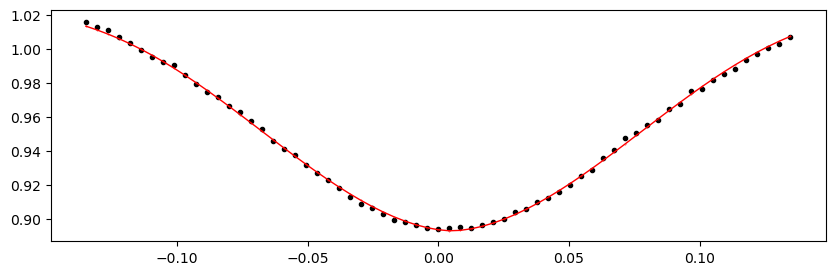

1780.0602778500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.51it/s]


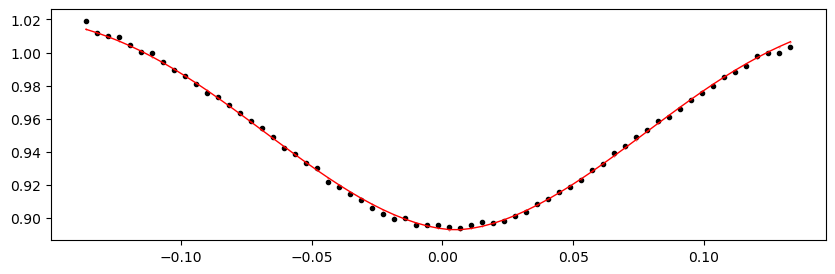

1780.38995055 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.35it/s]


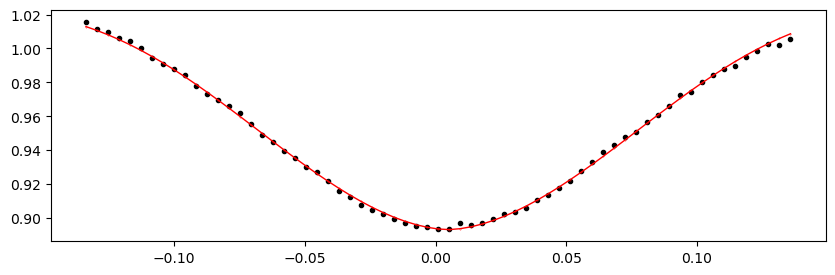

1780.71962325 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.12it/s]


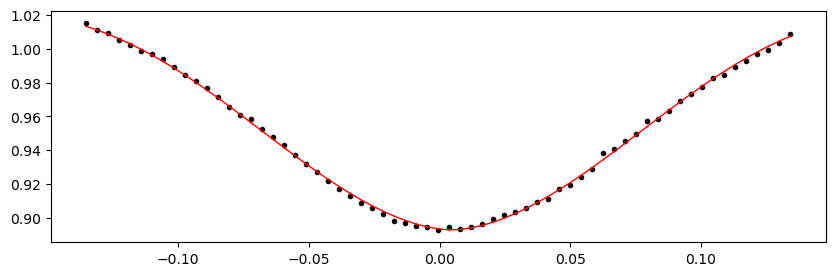

1781.0492959500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.08it/s]


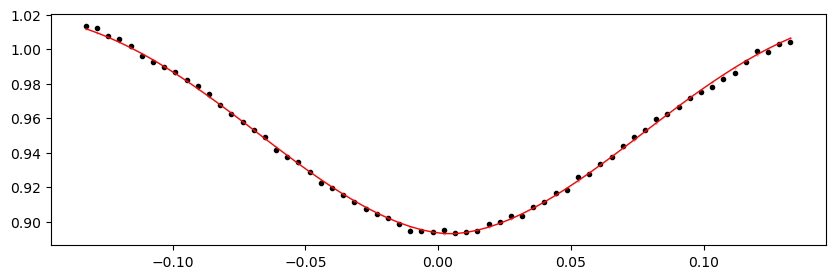

1781.3789686500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.45it/s]


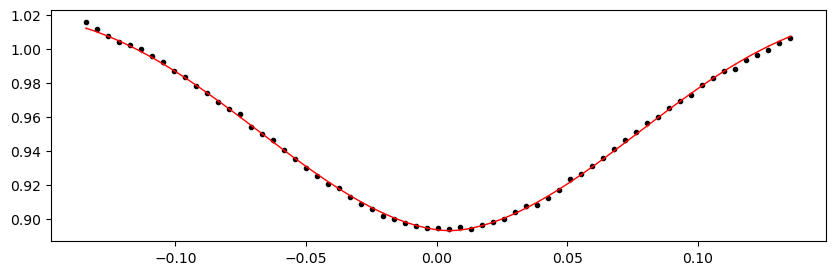

1781.70864135 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.66it/s]


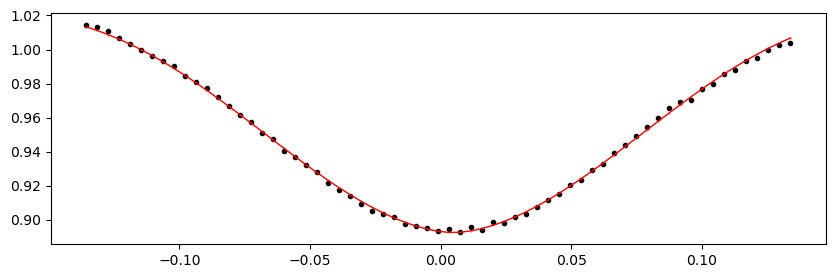

1782.03831405 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.46it/s]


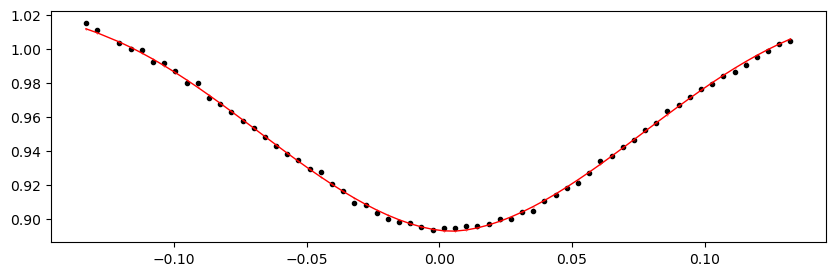

1782.36798675 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.70it/s]


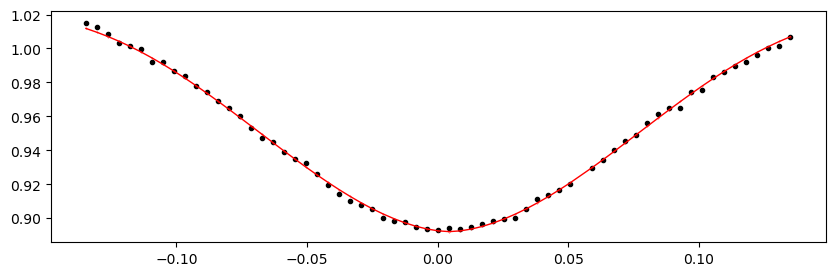

1782.6976594500002 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.32it/s]


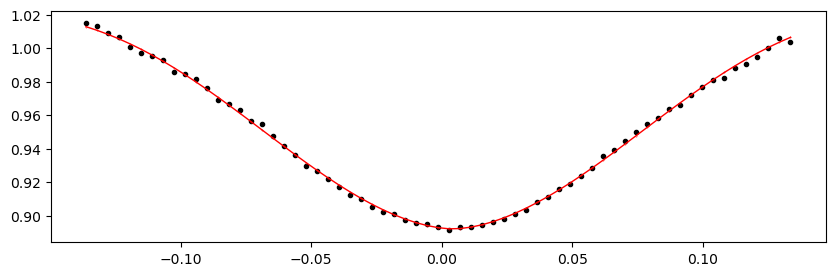

1783.0273321500001 1.0236974229571598 -0.12982154789033262 -0.26792291349889563


  4%|██                                                       | 372/10000 [00:00<00:23, 406.32it/s]Traceback (most recent call last):
  File "C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py", line 410, in log_probability_fitting
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr, mean_d, mean_Tau)
  File "C:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\etv\etv_functions.py", line 402, in log_likelihood_fitting
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )
  File "C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\numpy\core\fromnumeric.py", line 2172, in _sum_dispatcher
    def _sum_dispatcher(a, axis=None, dtype=None, out=None, keepdims=None,
KeyboardInterrupt
  4%|██▎                                                      | 408/10000 [

emcee: Exception while calling your likelihood function:
  params: [ 1.02416256 -0.13118881  0.00443659]
  args: (array([-0.13352358, -0.12931071, -0.12509784, -0.12088497, -0.1166721 ,
       -0.11245923, -0.10824636, -0.10403349, -0.09982062, -0.09560775,
       -0.09139488, -0.08718201, -0.08296914, -0.07875627, -0.0745434 ,
       -0.07033053, -0.06611766, -0.06190479, -0.05769192, -0.05347905,
       -0.04926618, -0.04505331, -0.04084044, -0.03662757, -0.0324147 ,
       -0.02820183, -0.02398896, -0.01977609, -0.01556323, -0.01135036,
       -0.00713749, -0.00292462,  0.00128825,  0.00550112,  0.00971399,
        0.01392686,  0.01813973,  0.0223526 ,  0.03077834,  0.03499121,
        0.03920408,  0.04341695,  0.04762982,  0.05184269,  0.05605556,
        0.06026843,  0.0644813 ,  0.06869417,  0.07290704,  0.07711991,
        0.08133278,  0.08554565,  0.08975852,  0.09397139,  0.09818425,
        0.10239712,  0.10660999,  0.11082286,  0.11503573,  0.1192486 ,
        0.12346147,  0

KeyboardInterrupt: 

## ETV O-C plot

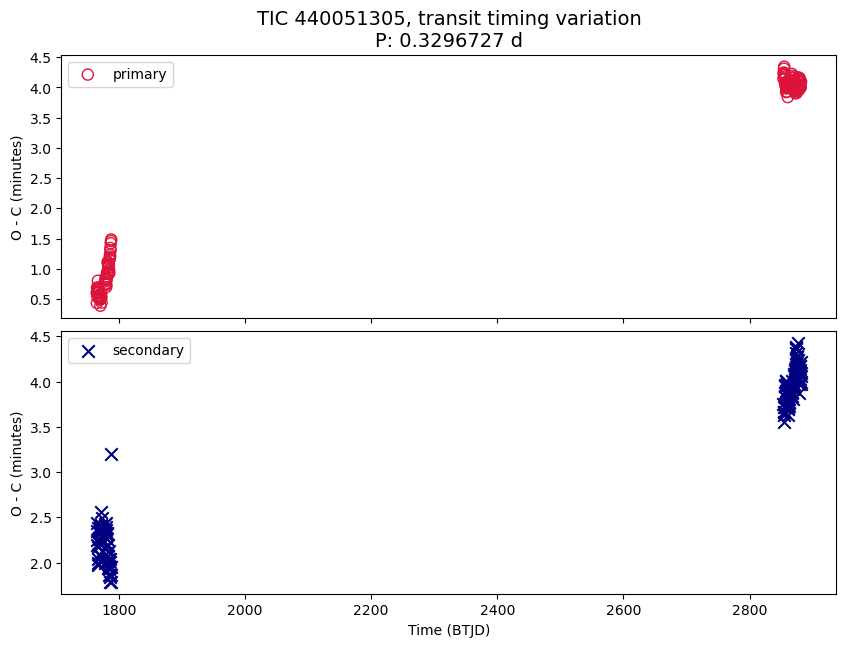

In [55]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, transit timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

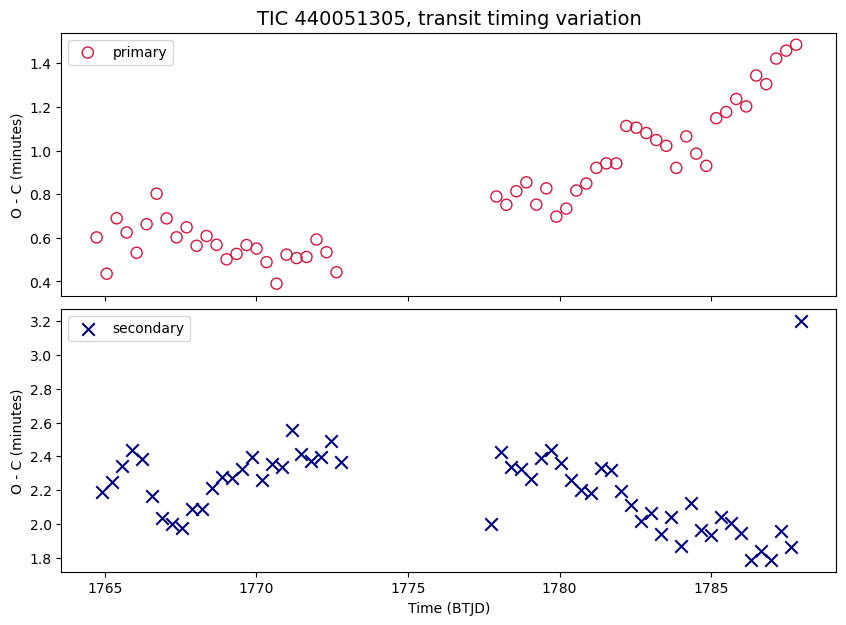

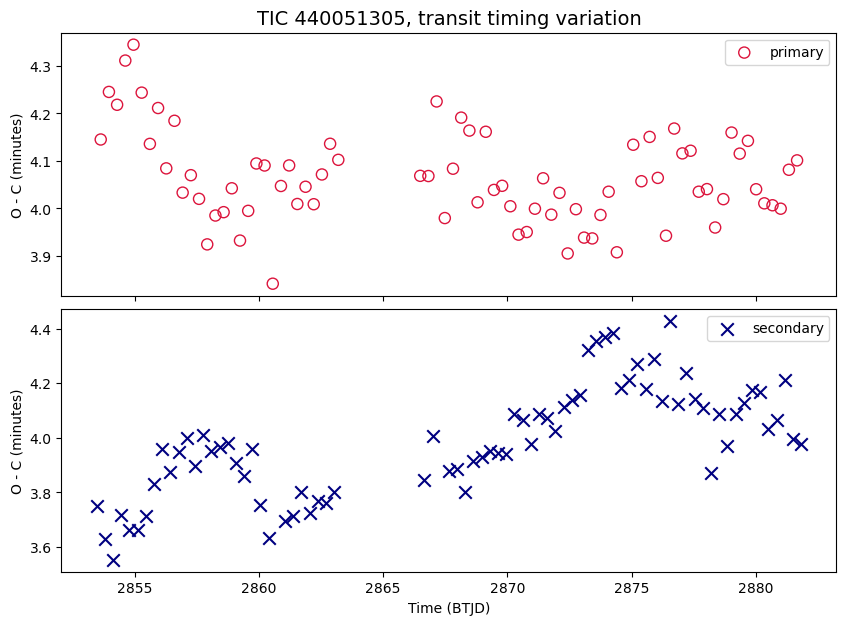

In [58]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1700, 1900),
    (2800, 3000),
]
title_suffix = "transit timing variation"

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

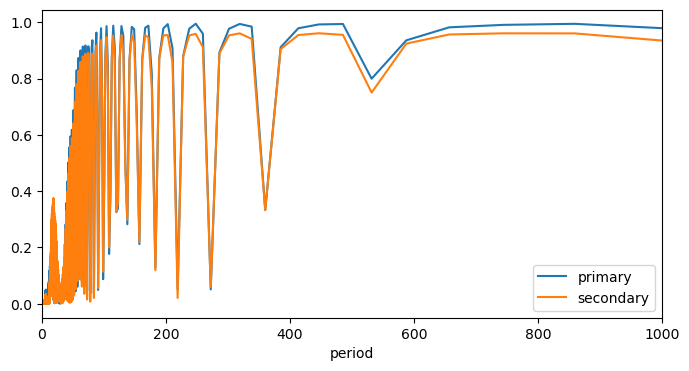

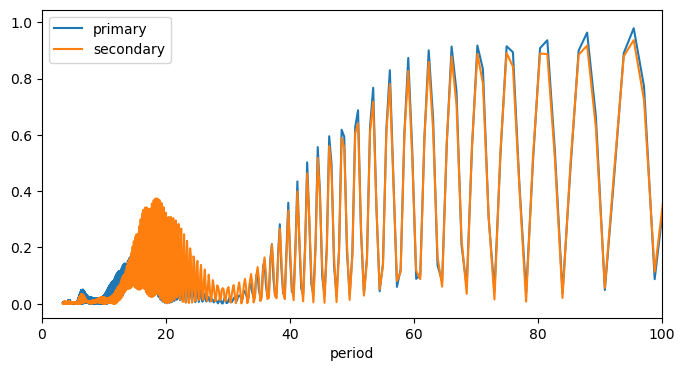

In [62]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## Results Summary

In [64]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Mightbe ETV for both primary and secondary in 2 separate sectors. The trend of primary is opposite of the one of secondary."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                            440051305
has_etv                                                                                                                               Y?
comments     Mightbe ETV for both primary and secondary in 2 separate sectors. The trend of primary is opposite of the one of secondary.
period                                                                                                                          0.329673
depth_pct_p                                                                                                                        13.82
depth_pct_s                                                                                                                        12.98
epoch_p                                                                                                                      1764.730497
epoch_s                                                                                                                      1764.895334
num_sectors                                                                                                                            2
time_span                                                                                                                        1117.43
time_start                                                                                                                       1764.69
time_end                                                                                                                         2882.12


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
440051305,Y?,Mightbe ETV for both primary and secondary in 2 separate sectors. The trend of primary is opposite of the one of secondary.,0.3296727,13.82,12.98,1764.7304973,1764.89533365,2,1117.43,1764.69,2882.12

